# Estimation of the Number of Votes Based on Board Game Features
Tomasz Jastrzębski ([Kaggle Link](https://www.kaggle.com/jastrzt2)),
Igor Piotrowiak ([Kaggle Link](https://www.kaggle.com/igorpiotrowiak))



In [38]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model  import Ridge
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

data = pd.read_csv('/content/bg_info.csv')
data_orginal=data.copy()

# 1. Analysis of Data Completion Rate

In [39]:
print("Number of records: " + str(data.shape[0]))
print("Number of features: " + str(data.shape[1]))
data.info()

Number of records: 25339
Number of features: 14
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25339 entries, 0 to 25338
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          25339 non-null  object 
 1   Geek Rating    25339 non-null  float64
 2   Avg rating     25339 non-null  float64
 3   Num of voters  25339 non-null  int64  
 4   Price          4150 non-null   float64
 5   Year           25113 non-null  float64
 6   Complexity     25339 non-null  float64
 7   Min players    25298 non-null  float64
 8   Max players    25298 non-null  float64
 9   Min time       24513 non-null  float64
 10  Max time       24513 non-null  float64
 11  Age            23841 non-null  float64
 12  Type 1         13327 non-null  object 
 13  Type 2         1828 non-null   object 
dtypes: float64(10), int64(1), object(3)
memory usage: 2.7+ MB


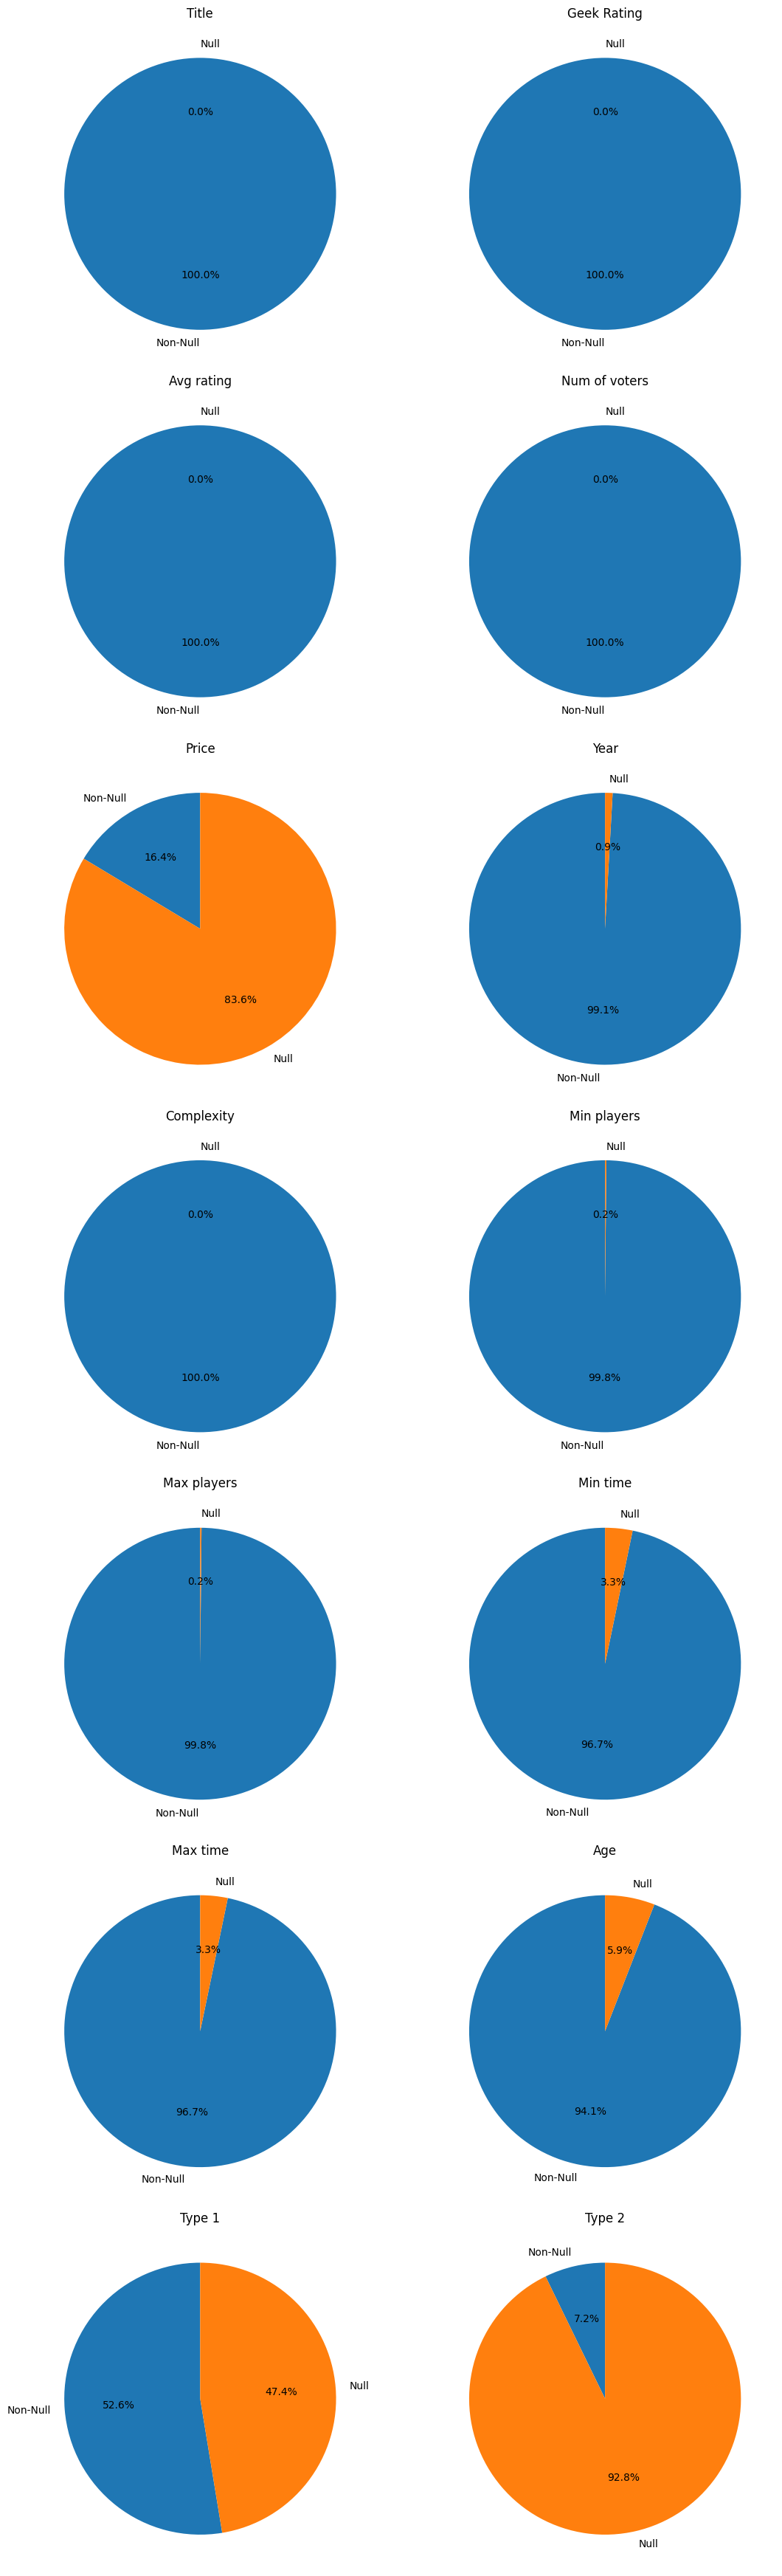

In [40]:
non_null_ratios = data.notnull().sum() / data.shape[0]

num_columns = 2
num_rows = (len(data.columns) + num_columns - 1) // num_columns

fig, axes = plt.subplots(num_rows, num_columns, figsize=(12, num_rows * 5))
axes = axes.flatten()

for i, column in enumerate(data.columns):
    non_null_count = non_null_ratios[column]
    null_count = 1 - non_null_count
    counts = [non_null_count, null_count]
    labels = ['Non-Null', 'Null']

    axes[i].pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"{column}")

for j in range(len(data.columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

The dataset consists of 25,339 games described by 14 features, including the title. All games have a fully completed dependent variable, "Num of voters". The columns "Geek Rating", "Avg rating", and "Complexity" are also fully completed.

There are minor missing values in the columns: "Age", "Max time", "Min time", "Max players", and "Min players".

Significant missing values are present in the "Price" column, as well as in the "Type 1" and "Type 2" columns, which describe the game's category.

In [41]:
rows_with_condition = data[(data['Type 1'].isnull()) & (data['Type 2'].notnull())]

print(len(rows_with_condition))

0


For further dataset analysis, we decided to exclude the "Price" feature due to significant missing values. Additionally, to simplify the model, we removed the "Type 2" feature, assuming that when a game has two assigned categories, "Type 1" represents the more important one. This assumption is reinforced by the fact that there are no records where "Type 2" appears without "Type 1", as demonstrated by the code above.

After discarding these two features, we removed rows with missing values, except for missing values in the "Type 1" column. This decision was based on the logic that, in this case, a missing value also conveys meaningful information.

In [42]:
data = data.drop(columns = ['Type 2', 'Price'])
data = data.loc[data.drop(columns=['Type 1']).notnull().all(axis=1)]

data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 23136 entries, 0 to 25338
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          23136 non-null  object 
 1   Geek Rating    23136 non-null  float64
 2   Avg rating     23136 non-null  float64
 3   Num of voters  23136 non-null  int64  
 4   Year           23136 non-null  float64
 5   Complexity     23136 non-null  float64
 6   Min players    23136 non-null  float64
 7   Max players    23136 non-null  float64
 8   Min time       23136 non-null  float64
 9   Max time       23136 non-null  float64
 10  Age            23136 non-null  float64
 11  Type 1         12181 non-null  object 
dtypes: float64(9), int64(1), object(2)
memory usage: 2.3+ MB


# 2. Features Ranges and Variability

In [43]:
data.describe()

,Geek Rating,Avg rating,Num of voters,Year,Complexity,Min players,Max players,Min time,Max time,Age
count,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000,23136.000000
mean,5.690122,6.472432,989.478864,2006.442643,1.950482,1.979815,5.929936,59.682659,91.973288,10.302256
std,0.363895,0.892705,4212.881500,80.786815,0.822186,0.700723,15.236176,414.892863,737.473240,2.805251
min,5.348000,1.300000,30.000000,-3500.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,5.511000,5.910000,60.000000,2004.000000,1.290000,2.000000,4.000000,20.000000,30.000000,8.000000
50%,5.545000,6.490000,137.000000,2014.000000,1.880000,2.000000,4.000000,30.000000,45.000000,10.000000
75%,5.679000,7.070000,448.000000,2018.000000,2.500000,2.000000,6.000000,60.000000,90.000000,12.000000
max,8.421000,9.760000,123256.000000,2025.000000,5.000000,10.000000,999.000000,60000.000000,84000.000000,21.000000


As seen in the description above, many features exhibit a wide range of values, especially at the higher end. The most notable feature is "Max time", where the third quartile represents only a tiny fraction of its maximum value.

Other features with extremely high variability include "Min time", "Max players", and "Num of voters". Among them, "Num of voters" has the largest range of variability.

Below there is a visualization of the distribution using violin and box plots.

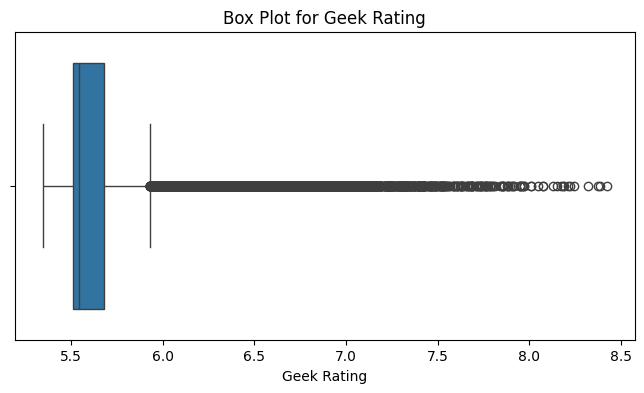

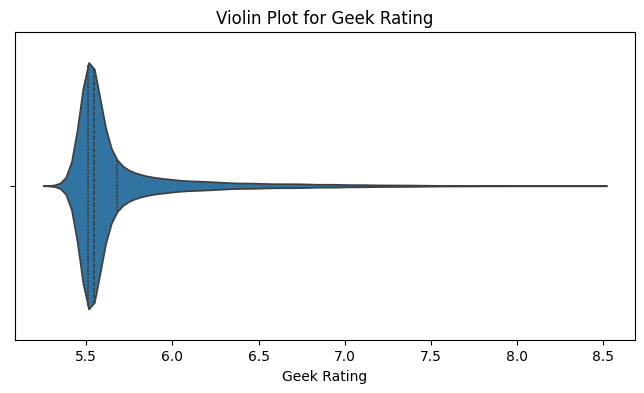

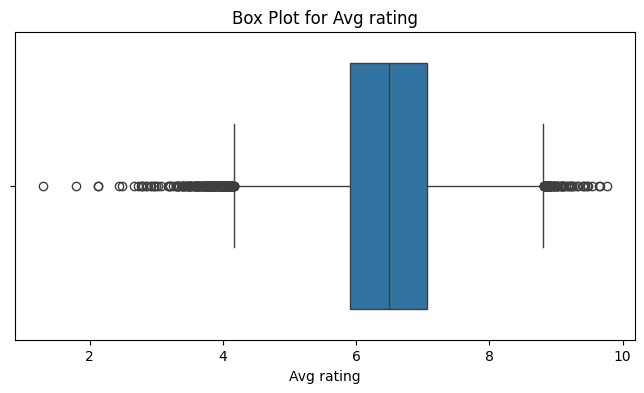

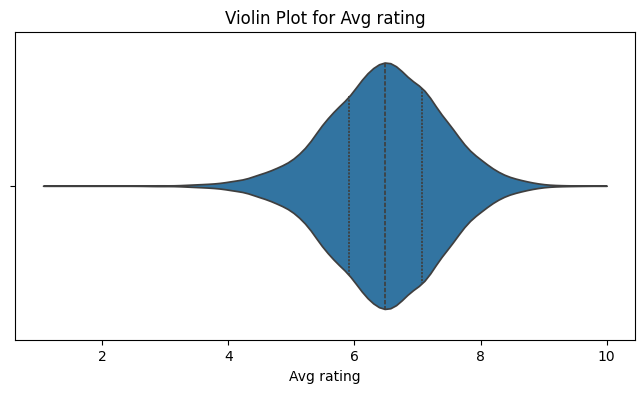

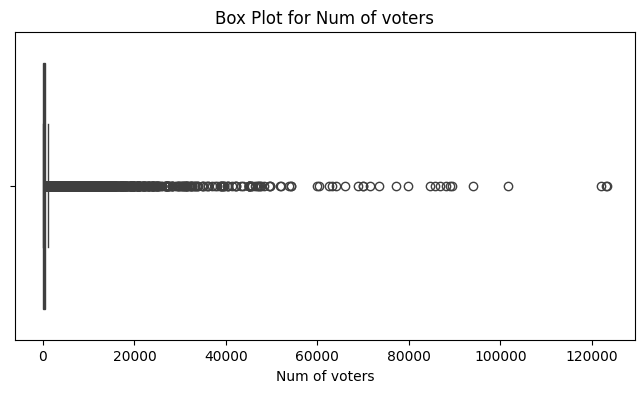

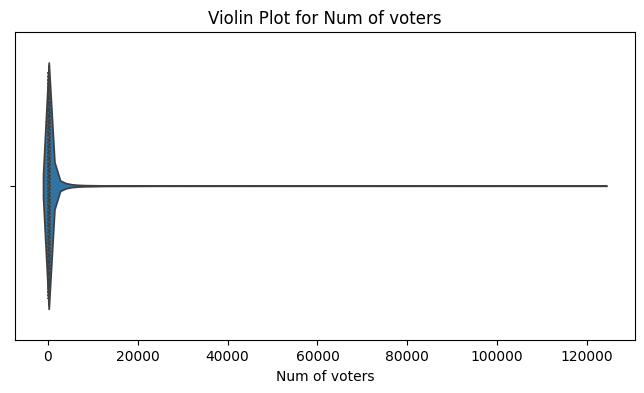

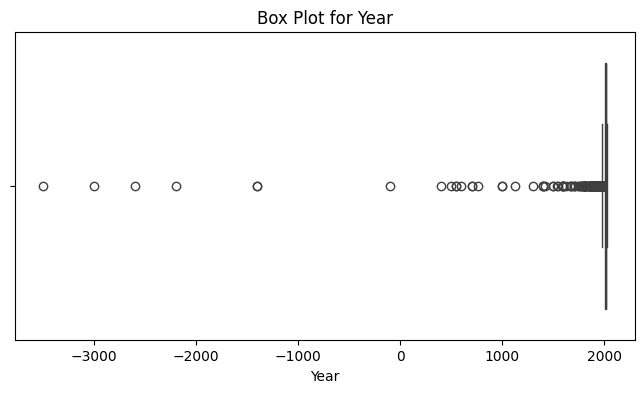

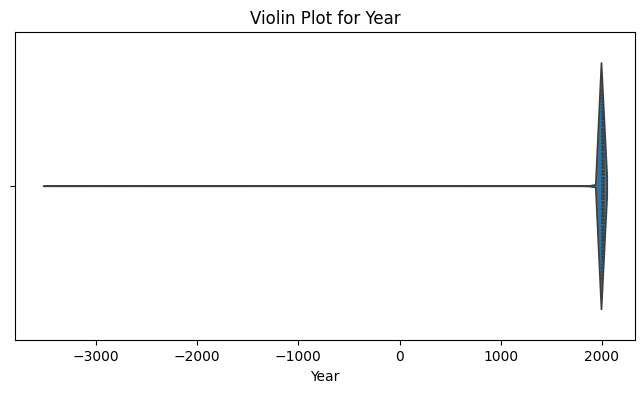

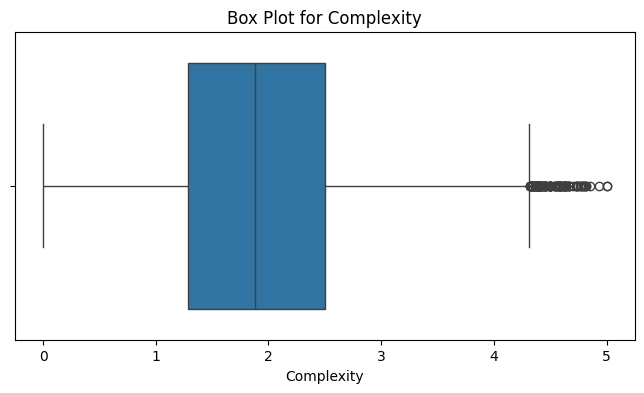

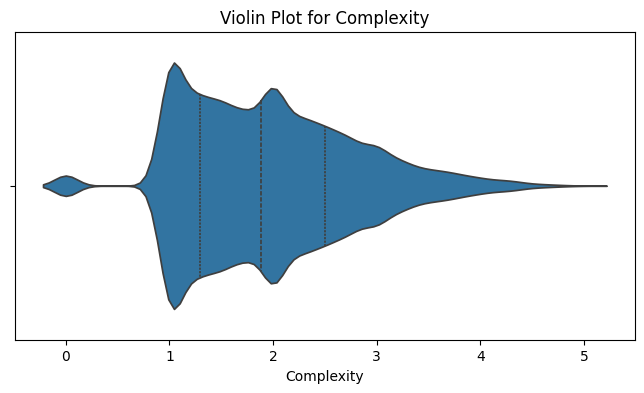

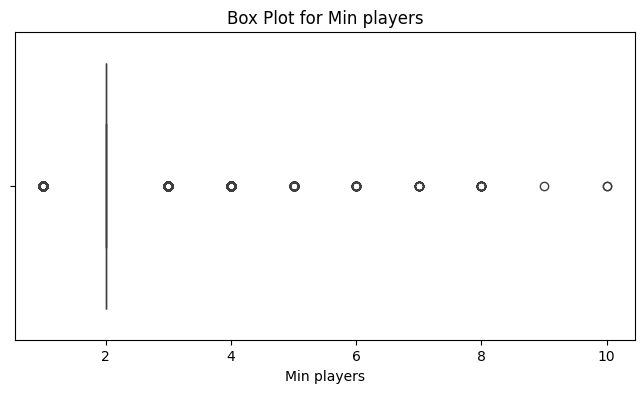

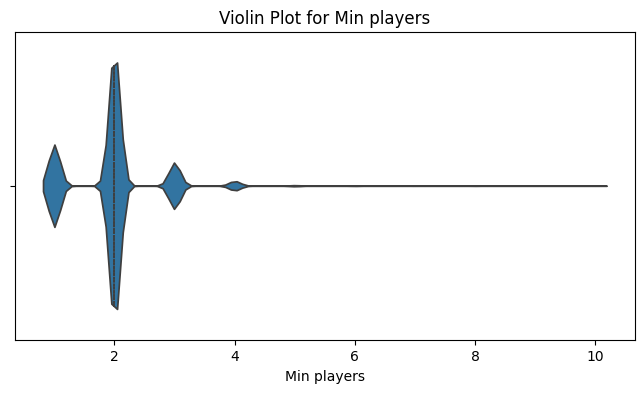

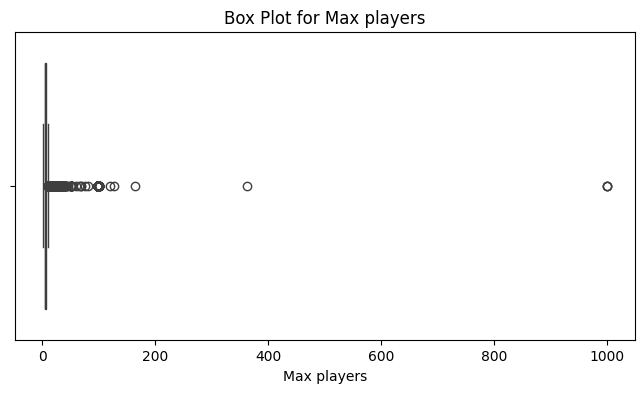

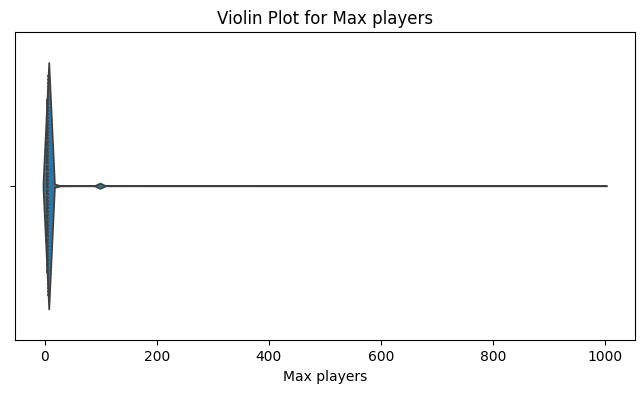

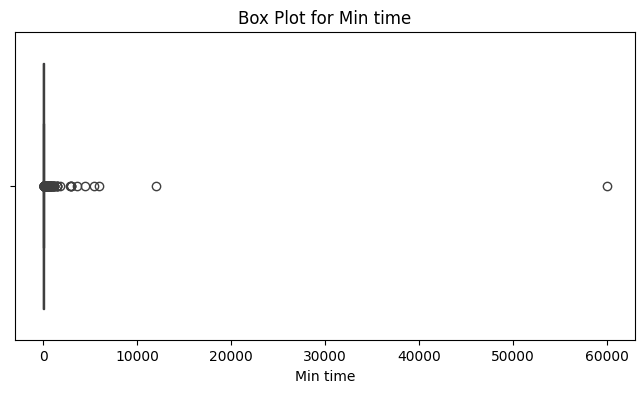

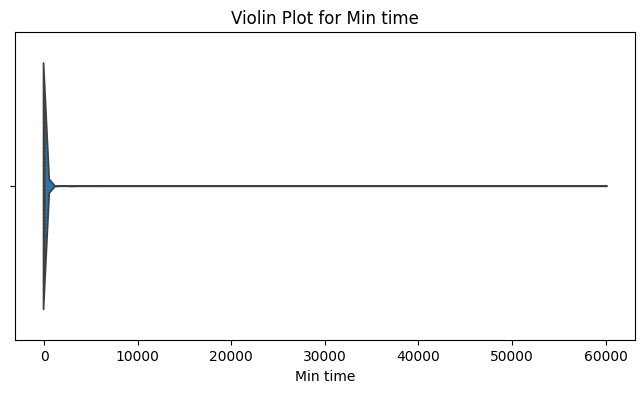

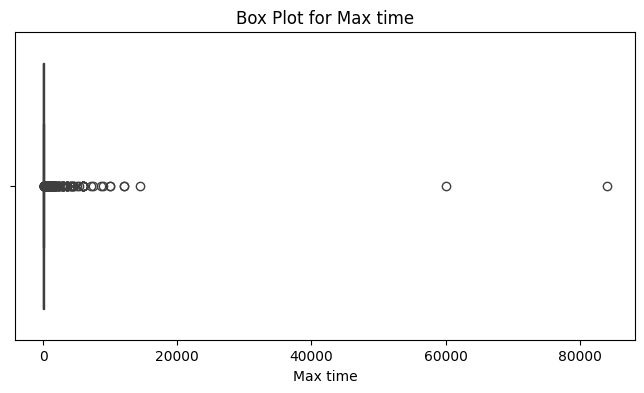

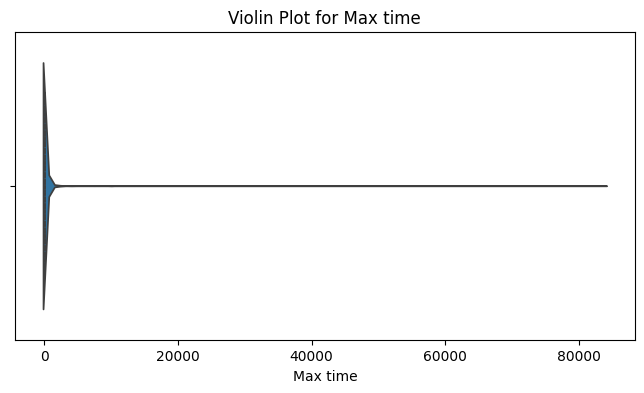

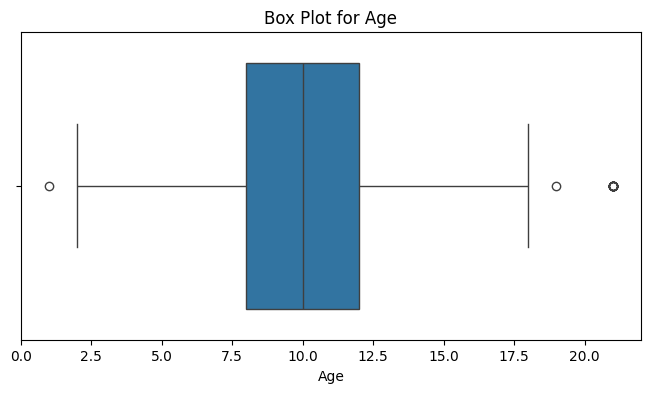

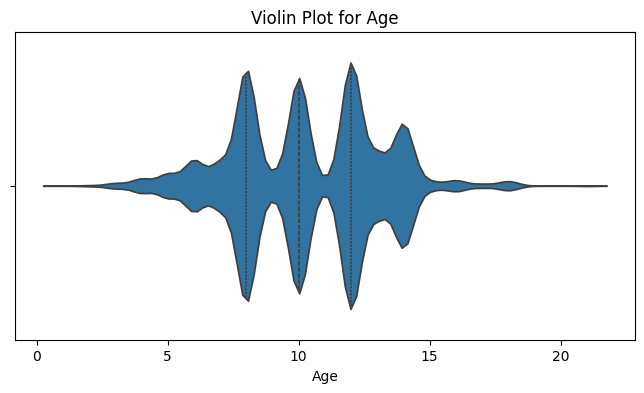

In [44]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns

for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Box Plot for {col}')
    plt.show()

    plt.figure(figsize=(8, 4))
    sns.violinplot(x=data[col], inner='quartile')
    plt.title(f'Violin Plot for {col}')
    plt.show()

To ensure that the order of column removal does not affect the results of outlier rejection, we added a temporary column "toRemove", which stores information about whether the value of any feature in a given row has been identified as an outlier.

Below, we present histograms for each numerical feature. The goal is to determine the best automatic selection method for each feature.

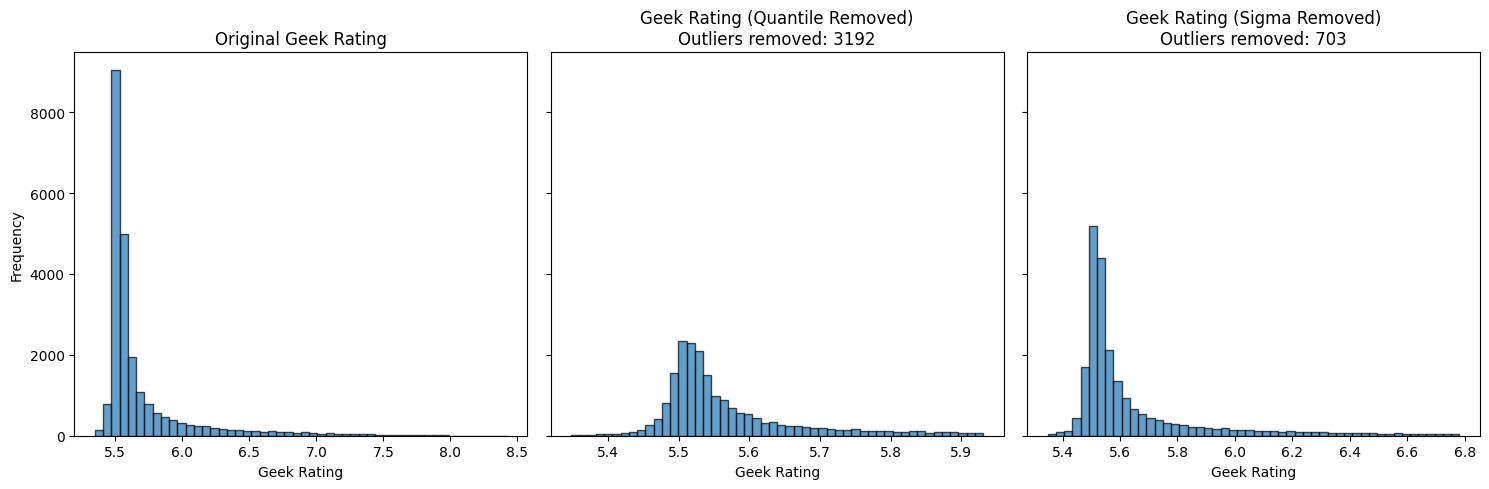

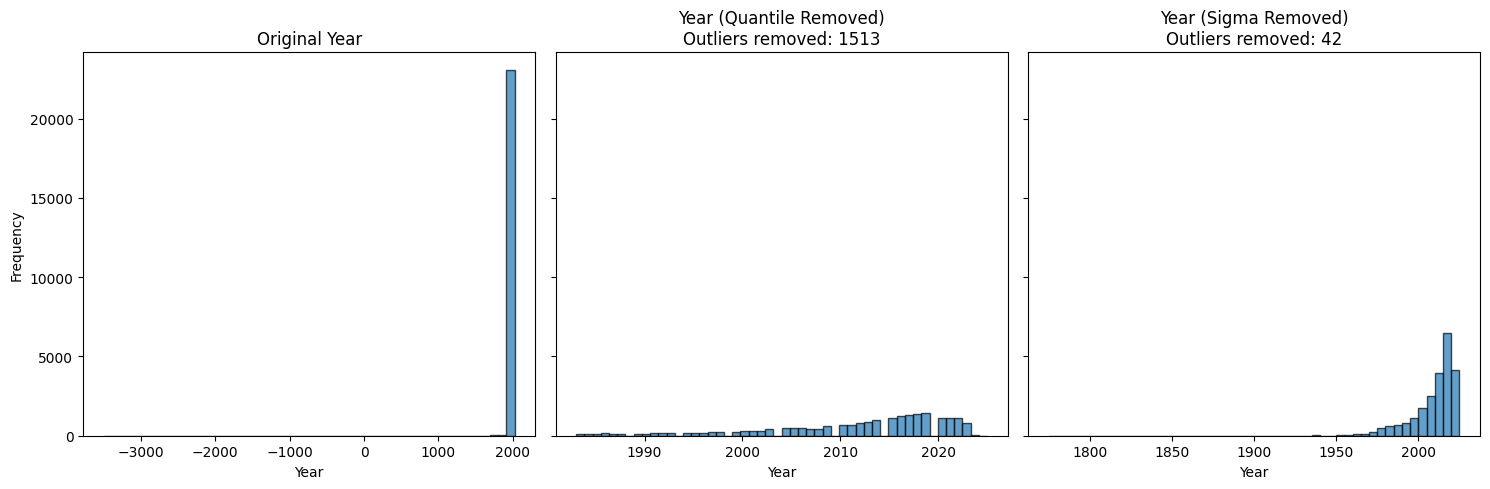

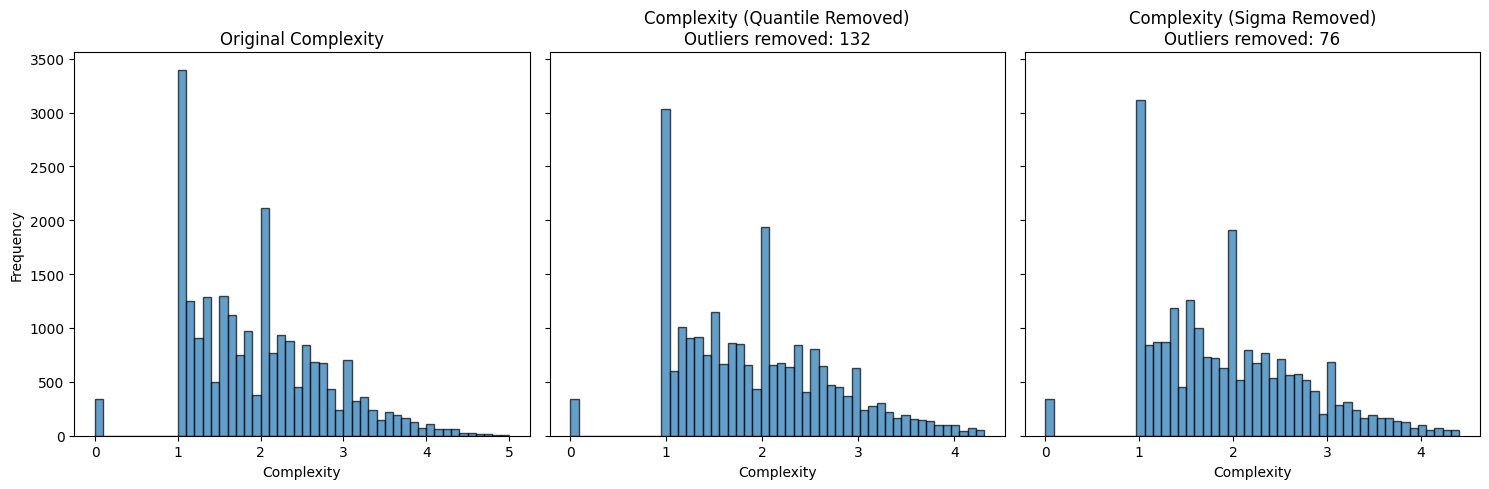

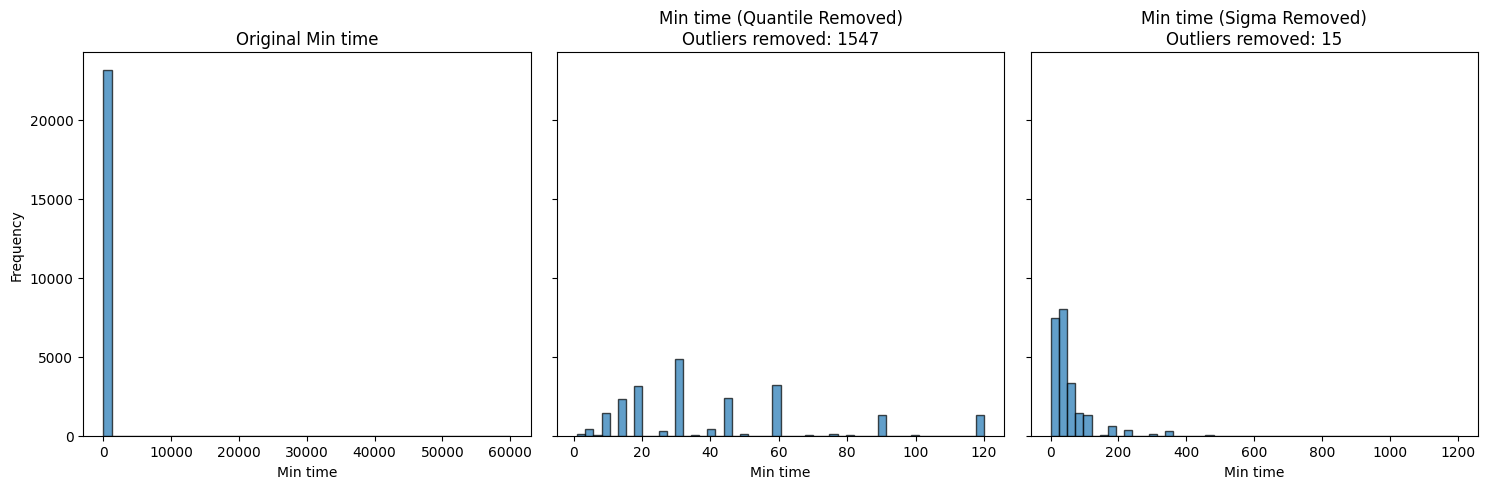

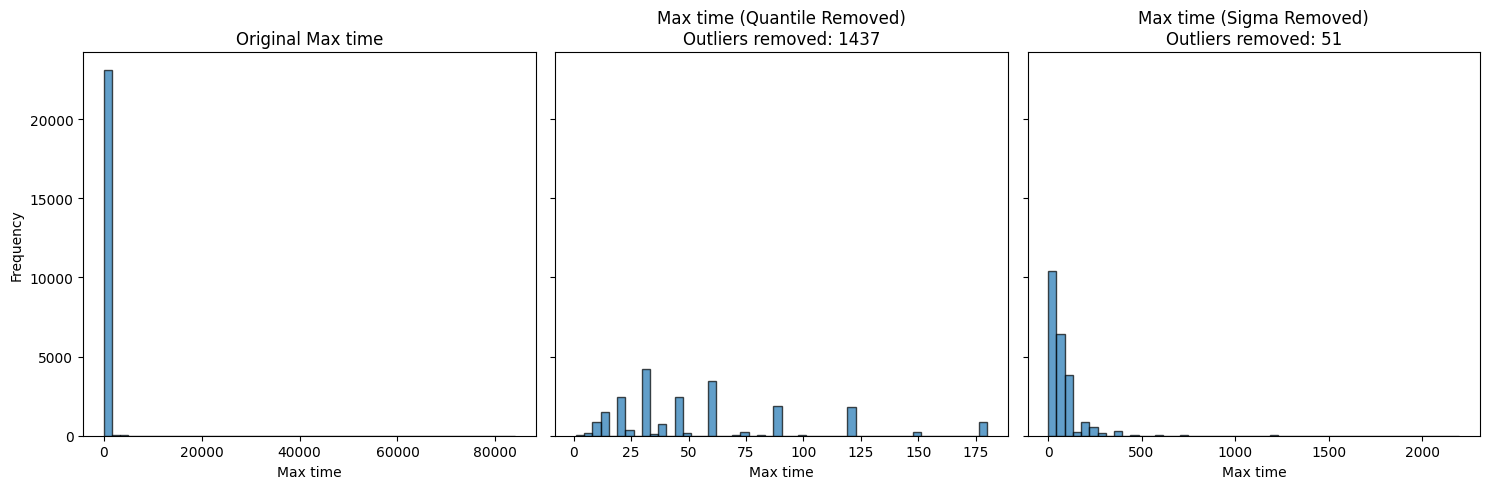

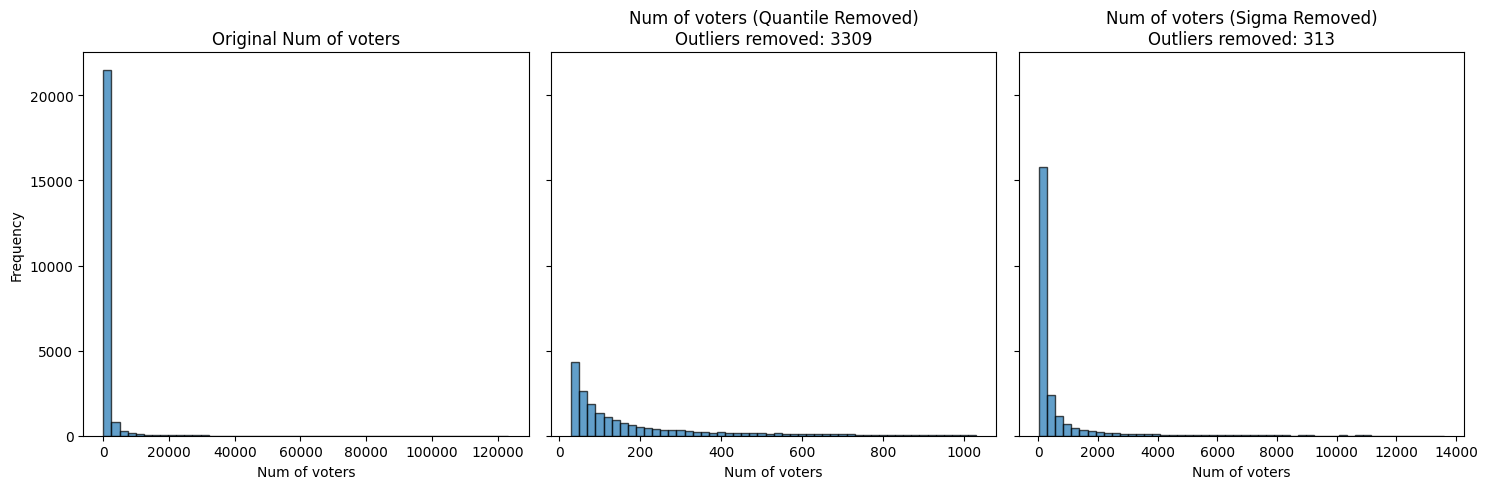

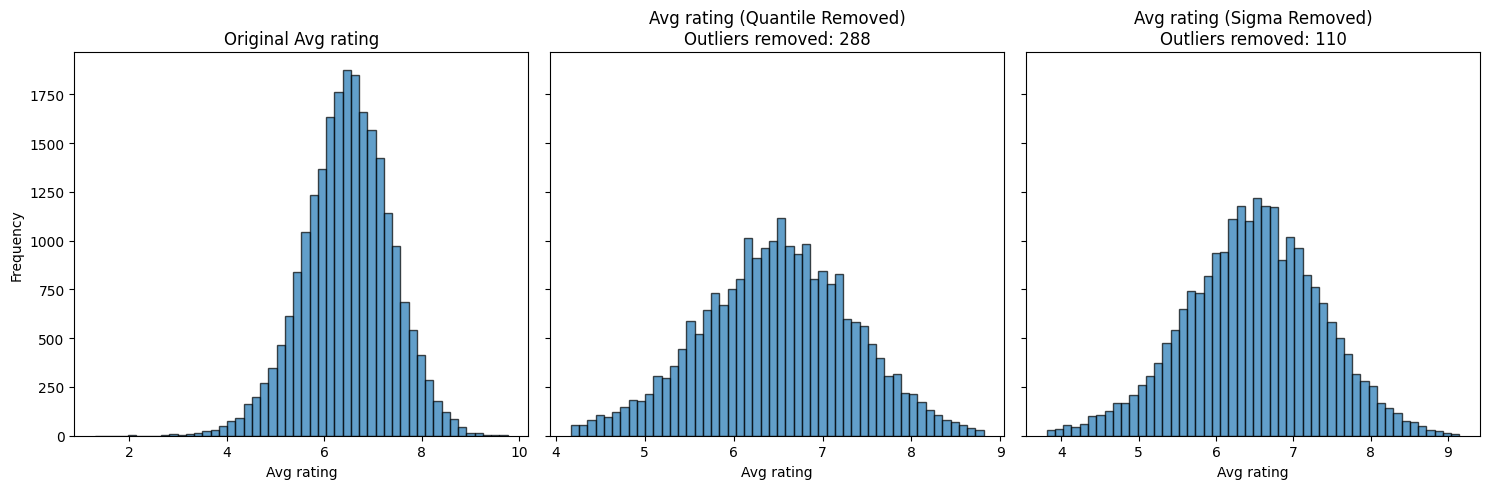

In [45]:
data['ToRemove'] = False

def mark_outliers_quantile(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), 'ToRemove'] = True

def mark_outliers_sigma(df, column):
    mean = df[column].mean()
    std = df[column].std()
    lower_bound = mean - 3 * std
    upper_bound = mean + 3 * std

    df.loc[(df[column] < lower_bound) | (df[column] > upper_bound), 'ToRemove'] = True

all_columns_with_outliners_to_drop = ['Geek Rating', 'Year', 'Complexity', 'Min time', 'Max time', 'Num of voters', 'Avg rating']

for col in all_columns_with_outliners_to_drop:
    original_data = data[col]

    data['ToRemove'] = False
    mark_outliers_quantile(data, col)
    quantile_removed_data = data[data['ToRemove'] == False][col]
    quantile_outliers_count = data['ToRemove'].sum()

    data['ToRemove'] = False
    mark_outliers_sigma(data, col)
    sigma_removed_data = data[data['ToRemove'] == False][col]
    sigma_outliers_count = data['ToRemove'].sum()

    fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
    axes[0].hist(original_data, bins=50, edgecolor='black', alpha=0.7)
    axes[0].set_title(f'Original {col}')
    axes[0].set_xlabel(col)
    axes[0].set_ylabel('Frequency')

    axes[1].hist(quantile_removed_data, bins=50, edgecolor='black', alpha=0.7)
    axes[1].set_title(f'{col} (Quantile Removed)\nOutliers removed: {quantile_outliers_count}')
    axes[1].set_xlabel(col)

    axes[2].hist(sigma_removed_data, bins=50, edgecolor='black', alpha=0.7)
    axes[2].set_title(f'{col} (Sigma Removed)\nOutliers removed: {sigma_outliers_count}')
    axes[2].set_xlabel(col)

    plt.tight_layout()
    plt.show()


To reject outlier values, we decided to use two automatic methods and a manual selection method. The choice of method depends on the shape of the distribution for each feature and its variability range. It can be observed that using standard deviation rejects fewer records than the interquartile range method.

The distributions of the 'Geek Rating', 'Complexity', and 'Avg rating' features resemble a normal distribution or a right- or left-skewed distribution. Additionally, their variability range is similar when using the interquartile range method and the standard deviation method. To minimize the rejection of useful data, we opted for the standard deviation method.

An exception is the 'Num of voters' feature. We decided to use the standard deviation method for this feature because we wanted to retain a larger portion of records with higher values, which correspond to more popular games.

The 'Min time' and 'Max time' features exhibit an enormous range with a relatively small number of records for higher values. Based on the shapes of their distributions, we concluded that using the standard deviation method would be inappropriate and would still retain many potentially outlying data points. Therefore, we decided to treat these features with the interquartile range method.

For the 'Year' column, we manually removed outlier observations. We chose 1950 as the cutoff year, as we are only analyzing modern games (this could be relevant from a business perspective).

In [46]:
quantile_columns = ['Min time', 'Max time']
sigma_columns = ['Geek Rating',  'Complexity', 'Avg rating', 'Num of voters']

for col in quantile_columns:
    mark_outliers_quantile(data, col)

for col in sigma_columns:
    mark_outliers_sigma(data, col)

data_copy = data.copy()

data = data[data['ToRemove'] == False]
data = data.drop(columns=['ToRemove'])
data = data[data['Year'] >= 1950]

Additionally, on the histograms, we observed an anomaly in the "Complexity" column. Values range from 1 to 5 continuously, but an outlying value of 0.0 appears. This is likely the result of missing data imputation. According to the assumptions from the first point, we reject rows with missing values, so we applied the same approach to rows where "Complexity" = 0.0.

Furthermore, we noticed a number of games with a release year of 2025. Anticipating errors for games that have not yet been published, we decided to exclude these rows as well.

In [47]:
data = data[data['Complexity'] != 0.0]
data = data[data['Year'] < 2025]
print(data.info())

<class 'pandas.core.frame.DataFrame'>
Index: 19869 entries, 706 to 25338
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Title          19869 non-null  object 
 1   Geek Rating    19869 non-null  float64
 2   Avg rating     19869 non-null  float64
 3   Num of voters  19869 non-null  int64  
 4   Year           19869 non-null  float64
 5   Complexity     19869 non-null  float64
 6   Min players    19869 non-null  float64
 7   Max players    19869 non-null  float64
 8   Min time       19869 non-null  float64
 9   Max time       19869 non-null  float64
 10  Age            19869 non-null  float64
 11  Type 1         9540 non-null   object 
dtypes: float64(9), int64(1), object(2)
memory usage: 2.0+ MB
None


For the attributes "Max players", "Min players", and "Age", we decided to convert them from quantitative to ordinal categorical attributes. This is because their values are solely natural numbers, and these features take on a relatively small number of unique values. The histograms for these features are presented as follows:

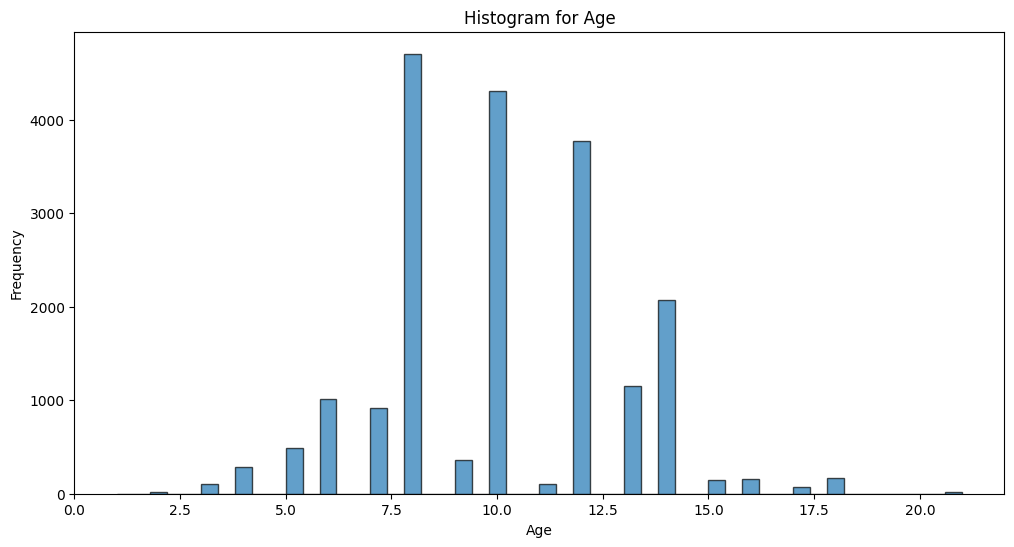

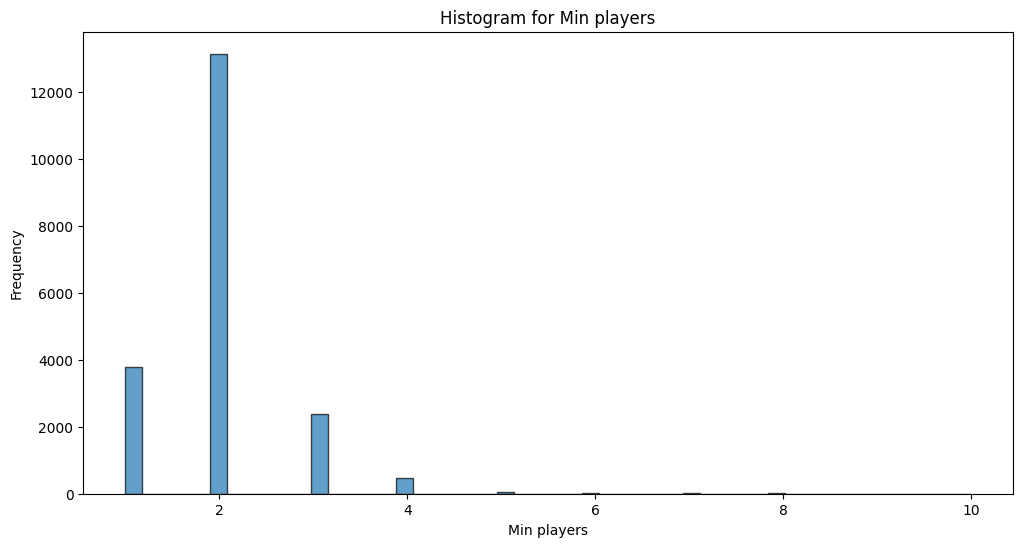

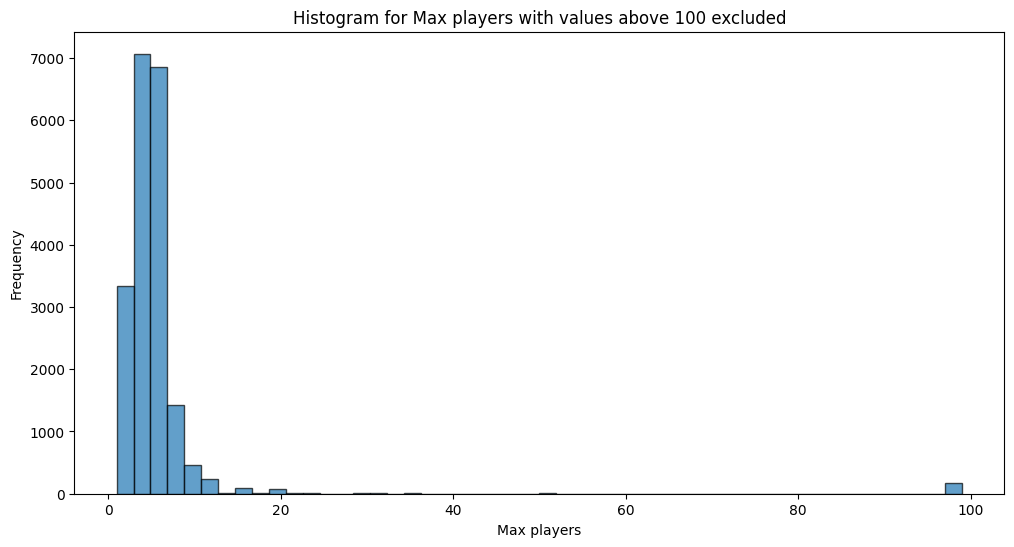

In [48]:
for col in ['Age', 'Min players']:
    plt.figure(figsize=(12, 6))
    plt.hist(data[col], bins=50, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.show()

plt.figure(figsize=(12, 6))
plt.hist(data[data['Max players'] < 100]['Max players'], bins=50, edgecolor='black', alpha=0.7)
plt.title('Histogram for Max players with values above 100 excluded')
plt.xlabel('Max players')
plt.ylabel('Frequency')

plt.show()


For "Age", we identified 3 peaks containing a significant portion of the data points, along with tails on both the left and right. This allowed us to divide the dataset into 5 bins.

Age_category
7-8      5060
11-13    4914
9-10     4415
<7       2840
>13      2640
Name: count, dtype: int64


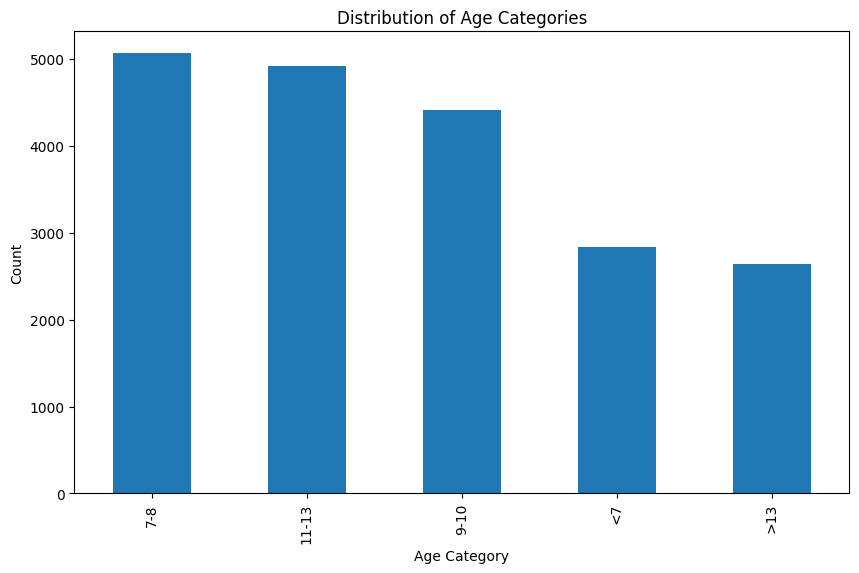

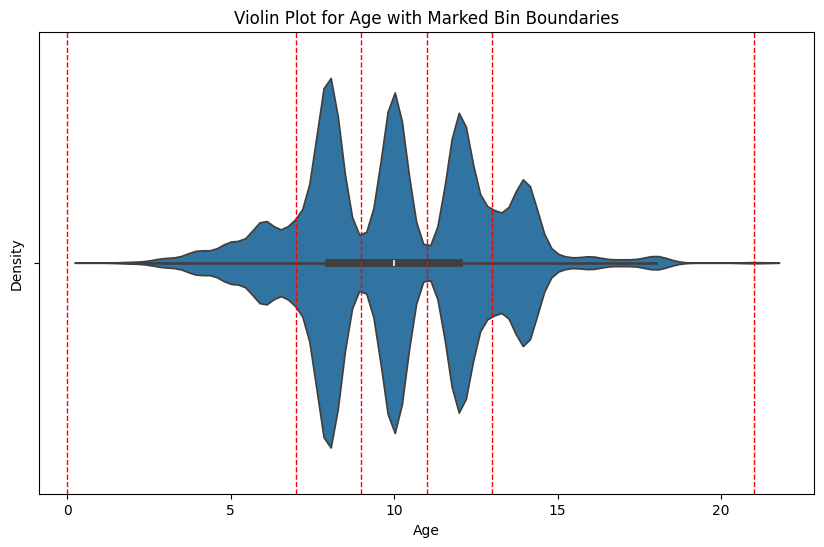

In [49]:
bins = [0, 7, 9, 11, 13, 21]
labels = ['<7', '7-8', '9-10', '11-13', '>13']

data['Age_category'] = pd.cut(data['Age'], bins=bins, labels=labels, include_lowest=True)

print(data['Age_category'].value_counts())

plt.figure(figsize=(10, 6))
data['Age_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Age Categories')
plt.xlabel('Age Category')
plt.ylabel('Count')
plt.show()

plt.figure(figsize=(10, 6))
sns.violinplot(x=data['Age'])
plt.title('Violin Plot for Age with Marked Bin Boundaries')
plt.xlabel('Age')
plt.ylabel('Density')

for boundary in bins:
    plt.axvline(boundary, color='red', linestyle='--', linewidth=1)

plt.show()


For "Max players", we decided to use bins with varying widths—smaller for the data from 1 to 10, where most of the records are concentrated, and larger for the tail containing a small portion of the total records.

Max_players_category
4        6850
6        3807
5        3051
2        2992
8        1158
10        376
1         353
11-15     287
>20       287
7         268
3         219
16-20     142
9          79
Name: count, dtype: int64


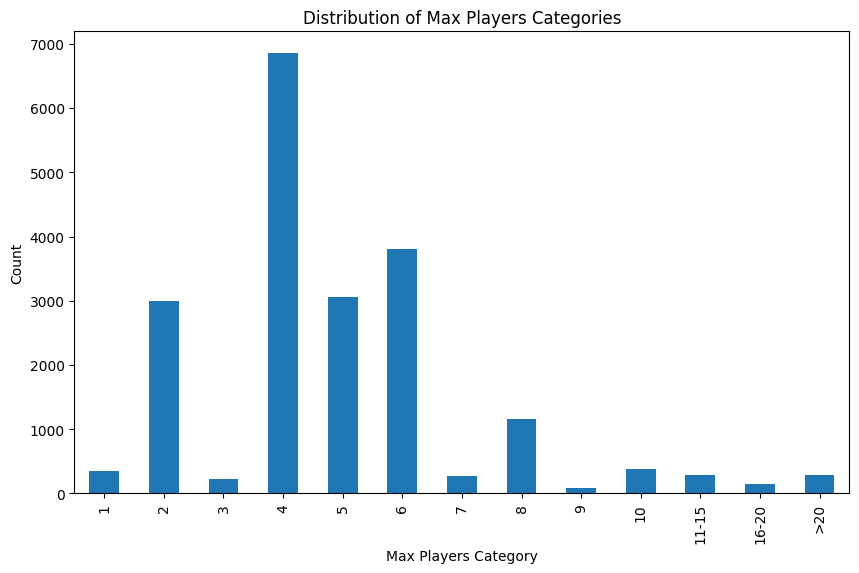

In [50]:
bins = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, float('inf')]
labels = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '16-20', '>20']

data['Max_players_category'] = pd.cut(data['Max players'], bins=bins, labels=labels, include_lowest=True)

print(data['Max_players_category'].value_counts())

plt.figure(figsize=(10, 6))
data['Max_players_category'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Max Players Categories')
plt.xlabel('Max Players Category')
plt.ylabel('Count')
plt.show()

The "Min players" attribute contains values ranging from 1 to 10, so we only changed the column type to categorical without further modifications.

Min_players_category
2.0     13140
1.0      3775
3.0      2386
4.0       477
5.0        51
6.0        20
7.0        12
8.0         7
10.0        1
Name: count, dtype: int64


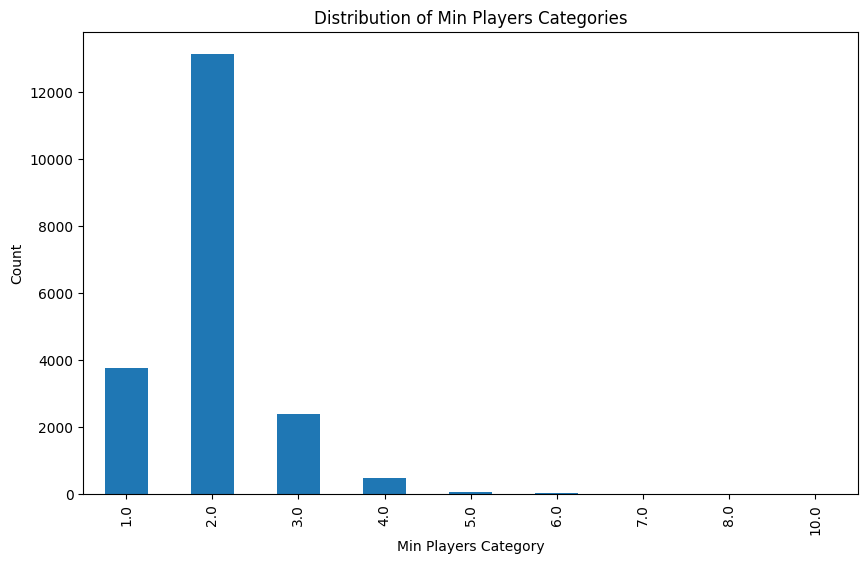

In [51]:
data['Min_players_category'] = data['Min players'].astype('category')

print(data['Min_players_category'].value_counts())

plt.figure(figsize=(10, 6))
data['Min_players_category'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Min Players Categories')
plt.xlabel('Min Players Category')
plt.ylabel('Count')
plt.show()

After converting these columns to ordinal, we discard the original columns.

In [52]:
data = data.drop(["Age", "Max players", "Min players"], axis=1)

The histograms after removing outlier values are presented as follows:

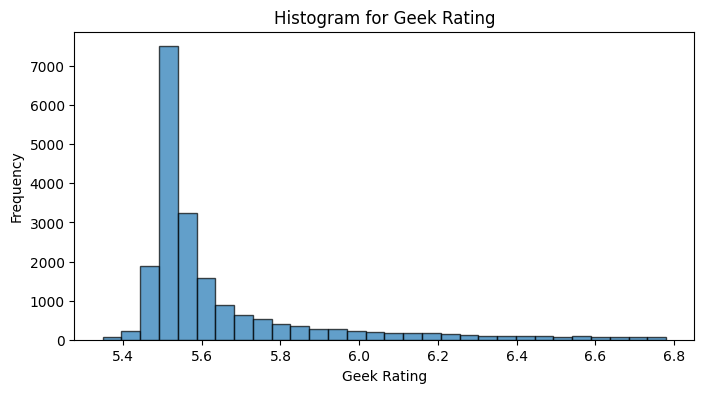

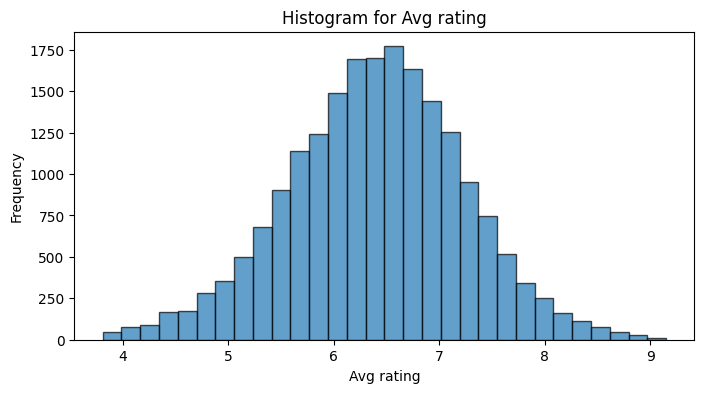

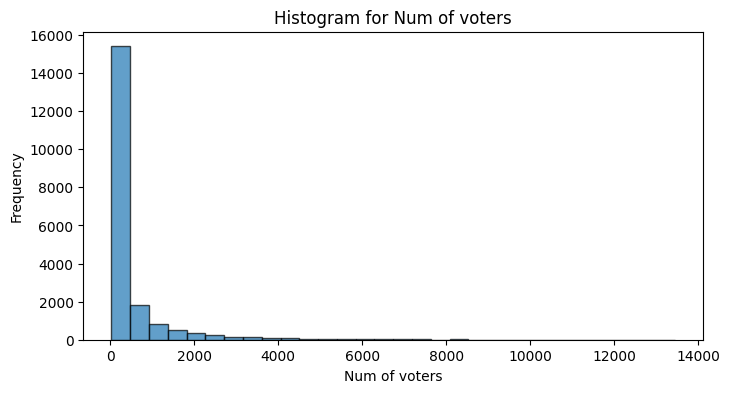

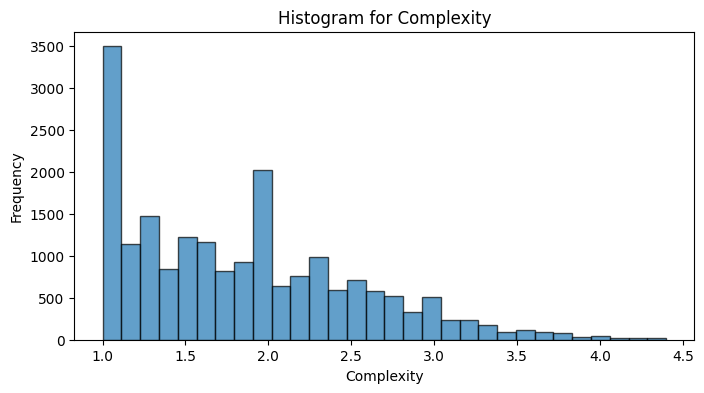

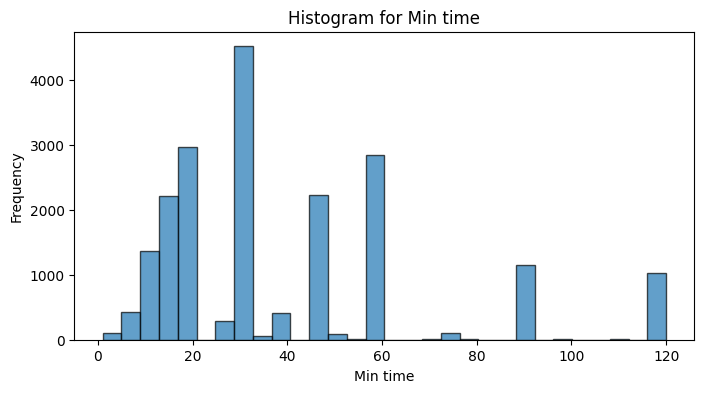

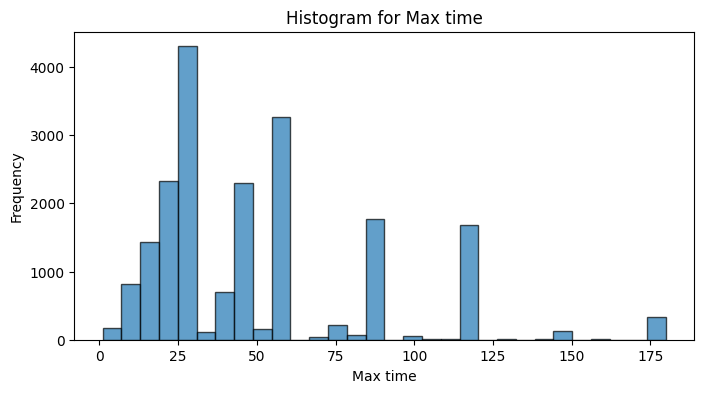

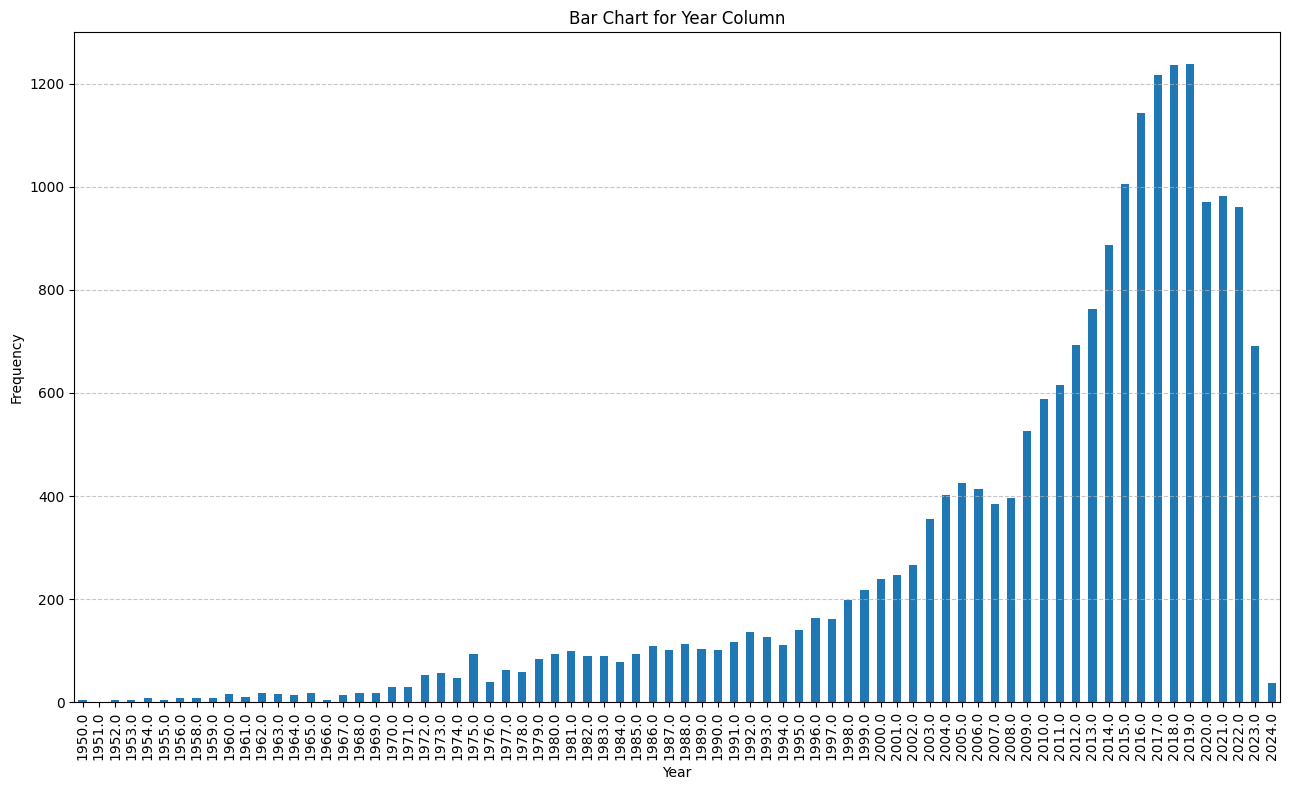

In [53]:
numeric_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()

if "Year" in numeric_columns:
    numeric_columns.remove("Year")

for col in numeric_columns:
    plt.figure(figsize=(8, 4))
    plt.hist(data[col], bins=30, edgecolor='black', alpha=0.7)
    plt.title(f'Histogram for {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

    plt.show()

plt.figure(figsize=(13, 8))
value_counts = data['Year'].value_counts().sort_index()
value_counts.plot(kind='bar')
plt.title('Bar Chart for Year Column')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.xticks(ticks=range(len(value_counts.index)), labels=value_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19869 entries, 706 to 25338
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Title                 19869 non-null  object  
 1   Geek Rating           19869 non-null  float64 
 2   Avg rating            19869 non-null  float64 
 3   Num of voters         19869 non-null  int64   
 4   Year                  19869 non-null  float64 
 5   Complexity            19869 non-null  float64 
 6   Min time              19869 non-null  float64 
 7   Max time              19869 non-null  float64 
 8   Type 1                9540 non-null   object  
 9   Age_category          19869 non-null  category
 10  Max_players_category  19869 non-null  category
 11  Min_players_category  19869 non-null  category
dtypes: category(3), float64(6), int64(1), object(2)
memory usage: 1.6+ MB


Finally, after removing the outlier values, the dataset contains just under 20,000 unique games.

# 3. Features Correlation

In [55]:

data_orginal = data_orginal.drop(columns=['Age'])
data_orginal = data_orginal.drop(columns=['Min players'])
data_orginal = data_orginal.drop(columns=['Max players'])
data_orginal = data_orginal.drop(columns=['Price'])

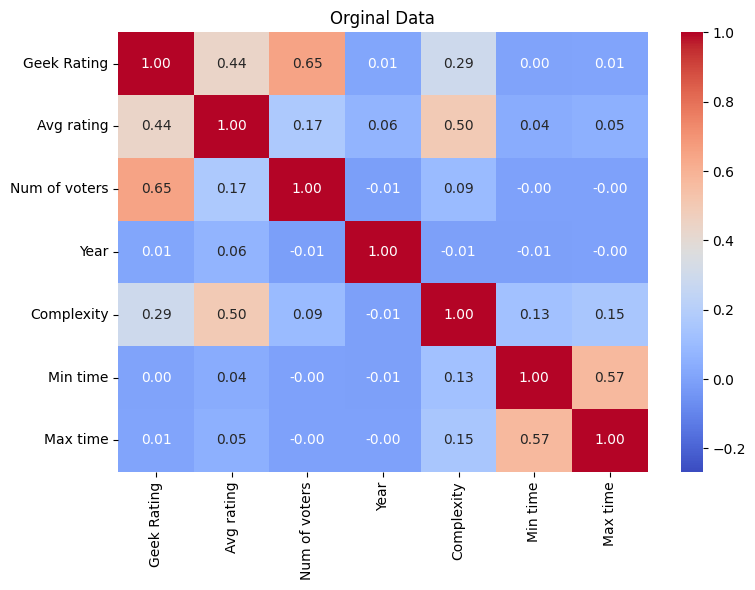

In [56]:
numeric_df_original = data_orginal.select_dtypes(include=['float64', 'int64'])
correlation_matrix_original = numeric_df_original.corr()
numeric_df_modified = data.select_dtypes(include=['float64', 'int64'])
correlation_matrix_modified = numeric_df_modified.corr()

vmin = min(correlation_matrix_original.min().min(), correlation_matrix_modified.min().min())
vmax = max(correlation_matrix_original.max().max(), correlation_matrix_modified.max().max())

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_original, annot=True, cmap="coolwarm", fmt=".2f", vmin=vmin, vmax=vmax)
plt.title('Orginal Data')
plt.tight_layout()
plt.show()

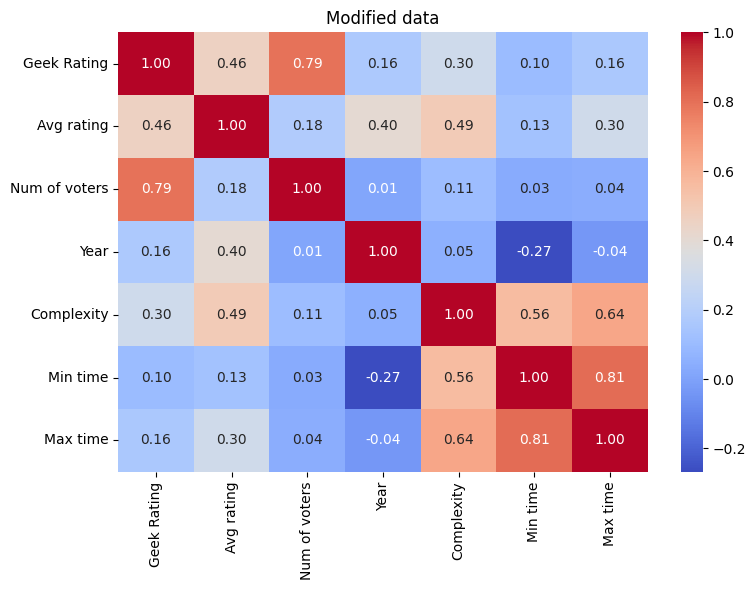

In [57]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix_modified, annot=True, cmap="coolwarm", fmt=".2f", vmin=vmin, vmax=vmax)
plt.title('Modified data')
plt.tight_layout()
plt.show()


As shown above, the most highly correlated features are 'Min Time' and 'Min Time', with a correlation of 0.81. We decided that this correlation is still too low to justify removing one of them at this stage. Other notable correlations include 'Avg rating' and 'Geek Rating', 'Year' and 'Complexity', 'Min time' and 'Complexity', as well as 'Max time' and 'Complexity'. The least correlated features are 'Num of voters' and 'Year'.

The feature most strongly correlated with our target variable ('Num of voters') is 'Geek Rating'. Other features show only weak correlations with it.

In general, it can be observed that after "cleaning" the data from extreme values, many features show correlations with other features.

Based on the performed actions, we decided to formulate the following hypothesis: the Geek Rating will have the greatest impact on predicting the value of Num of Voters.

# Data Processing and Regression Models

The data after exploration looks as follows:

In [58]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19869 entries, 706 to 25338
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Title                 19869 non-null  object  
 1   Geek Rating           19869 non-null  float64 
 2   Avg rating            19869 non-null  float64 
 3   Num of voters         19869 non-null  int64   
 4   Year                  19869 non-null  float64 
 5   Complexity            19869 non-null  float64 
 6   Min time              19869 non-null  float64 
 7   Max time              19869 non-null  float64 
 8   Type 1                9540 non-null   object  
 9   Age_category          19869 non-null  category
 10  Max_players_category  19869 non-null  category
 11  Min_players_category  19869 non-null  category
dtypes: category(3), float64(6), int64(1), object(2)
memory usage: 1.6+ MB


Our assumption was to remove all missing values based on the premise that the game publisher can easily gather data to fill in the missing columns.

We converted the "Type 1" column into binary columns using "get_dummies". The columns with ordinal categorical attributes were mapped to integers from 1 to n, where n is the number of unique values for the attribute. Since the game title is considered irrelevant for regression, we removed it from the dataset.

In [59]:
orginal_data = data.copy()
data = pd.get_dummies(data, columns=['Type 1'], drop_first=True)


for col in data.select_dtypes(include=['category']).columns:
    data[col] = data[col].cat.codes + 1

data = data.drop(columns=['Title'])

After data processing, new binary columns were created from the "Type 1" column, and the ordinal columns changed their type from "category" to integers.

In [60]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19869 entries, 706 to 25338
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Geek Rating           19869 non-null  float64
 1   Avg rating            19869 non-null  float64
 2   Num of voters         19869 non-null  int64  
 3   Year                  19869 non-null  float64
 4   Complexity            19869 non-null  float64
 5   Min time              19869 non-null  float64
 6   Max time              19869 non-null  float64
 7   Age_category          19869 non-null  int8   
 8   Max_players_category  19869 non-null  int8   
 9   Min_players_category  19869 non-null  int8   
 10  Type 1_Children's     19869 non-null  bool   
 11  Type 1_Customizable   19869 non-null  bool   
 12  Type 1_Family         19869 non-null  bool   
 13  Type 1_Party          19869 non-null  bool   
 14  Type 1_Strategy       19869 non-null  bool   
 15  Type 1_Thematic       

Next, we split the dataset into the feature matrix X and the target variable y, create new features, and perform a train-test split:

In [61]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

X = data.drop(columns=['Num of voters'])
y = data['Num of voters']

X2 = X.copy()

data_without_new_columns = data.copy()

X['Geek_square'] = X['Geek Rating'] * X['Geek Rating']
X['Complexity_square'] = X['Complexity'] * X['Complexity']
X['Complexity_x_Geek_Rating'] = X['Geek Rating'] * X['Complexity']
X['Avg_Rating_square'] = X['Avg rating'] * X['Avg rating']
X['Avg_Rating_x_Rating_Geek'] = X['Geek Rating'] * X['Avg rating']
X['Max_Time_x_Complexity'] = X['Max time'] * X['Complexity']




We created new features by combining the features that showed the largest increase in the R² score during the greedy feature selection process.

For additional analysis of model effectiveness, we wrote our own function that checks how many predictions match the actual values, allowing for an error margin of +/- 10%.

In [62]:
def calculate_percentage_within_margin(y_true, y_pred, margin=0.1):
    lower_bound = y_true * (1 - margin)
    upper_bound = y_true * (1 + margin)

    count_of_predictions_within_margin = sum((y_pred >= lower_bound) & (y_pred <= upper_bound))

    percentage_within_range = (count_of_predictions_within_margin / len(y_true)) * 100
    return str(round(percentage_within_range, 2)) + "%"



## 1. Simple Linear Model

The basic model, which will serve as a reference point for other models, is a simple polynomial regression model applied to the scaled feature matrix without any other modifications.

In [63]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from math import sqrt

X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=2137)

model = LinearRegression()

model.fit(X_train2, y_train2)

y_pred = model.predict(X_test2)

mse = mean_squared_error(y_test2, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test2, y_pred)

print("RMSE:", rmse)
print("R2:", r2)
print("Percentage of predictions within 10% margin:", calculate_percentage_within_margin(y_test2, y_pred))

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

intercept = model.intercept_
coefficients = model.coef_
feature_names = X.columns

feature_coefs = list(zip(feature_names, coefficients))
feature_coefs_with_intercept = [('Intercept', intercept)] + feature_coefs
sorted_feature_coefs = sorted(feature_coefs_with_intercept, key=lambda x: abs(x[1]), reverse=True)

print("\nCoefficients sorted by absolute value:")
for feature, coef in sorted_feature_coefs:
    print(f"Feature: {feature}, Coefficient: {coef}")


RMSE: 582.6830229016673
R2: 0.6930983474838329
Percentage of predictions within 10% margin: 8.28%
Coefficients: [ 3.87016172e+03 -2.32424755e+02 -5.51809029e+00 -4.62052415e+01
 -8.53917012e-01  1.99055054e-01  2.42915813e-01  6.86917905e+00
  2.63846536e+00 -1.75788516e+01 -8.71618897e+01  1.79121273e+02
  2.52430941e+02 -1.60900846e+02 -5.32059029e+01  6.73237542e+00]
Intercept: -8709.695010919564

Coefficients sorted by absolute value:
Feature: Intercept, Coefficient: -8709.695010919564
Feature: Geek Rating, Coefficient: 3870.1617214240537
Feature: Type 1_Party, Coefficient: 252.43094128916516
Feature: Avg rating, Coefficient: -232.42475499839344
Feature: Type 1_Family, Coefficient: 179.12127310943393
Feature: Type 1_Strategy, Coefficient: -160.90084563947306
Feature: Type 1_Customizable, Coefficient: -87.16188967541541
Feature: Type 1_Thematic, Coefficient: -53.20590286741672
Feature: Complexity, Coefficient: -46.20524145738711
Feature: Type 1_Children's, Coefficient: -17.578851637

It's worth noting that before standardization, the largest coefficient was the intercept, which, like most other features, received a negative value. This indicates that the model was highly influenced by Geek Rating, which, when not standardized, has a considerable range of variability compared to other features. Geek Rating is by far the best feature for predicting the number of votes for a given board game, most likely due to its high correlation with the target variable.

However, in this form, the model is difficult to interpret in depth, and the features require standardization.

In [64]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)
X_train_scaled, X_test_scaled, _, _ = train_test_split(X_scaled, y, test_size=0.2, random_state=2137)

In [65]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from math import sqrt

model = LinearRegression()

model.fit(X_train_scaled, y_train)

y_pred = model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
rmse = sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("RMSE:", rmse)
print("R2:", r2)
print("Percentage of predictions within 10% margin:", calculate_percentage_within_margin(y_test, y_pred))

print("Coefficients:", model.coef_)
print("Intercept:", model.intercept_)

intercept = model.intercept_
coefficients = model.coef_
feature_names = X.columns

feature_coefs = list(zip(feature_names, coefficients))
feature_coefs_with_intercept = [('Intercept', intercept)] + feature_coefs
sorted_feature_coefs = sorted(feature_coefs_with_intercept, key=lambda x: abs(x[1]), reverse=True)

print("\nCoefficients sorted by absolute value:")
for feature, coef in sorted_feature_coefs:
    print(f"Feature: {feature}, Coefficient: {coef}")

RMSE: 443.36654832747536
R2: 0.8223110818145692
Percentage of predictions within 10% margin: 13.09%
Coefficients: [-4.58925830e+03  1.61862145e+04 -3.78126519e+01  1.23367911e+03
 -3.51719829e+01 -2.04436210e+00  9.63773183e+00  1.62926115e+01
 -1.52986883e+01  9.48858022e+00  1.04688718e+01  2.74344267e+01
  4.05671610e+01 -1.07608563e+01  3.72867640e+01  1.07951821e-01
  1.25097884e+04  7.23547419e+01 -1.40127995e+03  1.58311458e+03
 -2.18633769e+04  5.48329522e+01]
Intercept: 499.49314170533523

Coefficients sorted by absolute value:
Feature: Avg_Rating_x_Rating_Geek, Coefficient: -21863.376935782413
Feature: Avg rating, Coefficient: 16186.214522411856
Feature: Geek_square, Coefficient: 12509.788390856304
Feature: Geek Rating, Coefficient: -4589.258302793506
Feature: Avg_Rating_square, Coefficient: 1583.1145801762477
Feature: Complexity_x_Geek_Rating, Coefficient: -1401.2799461967747
Feature: Complexity, Coefficient: 1233.6791090324202
Feature: Intercept, Coefficient: 499.4931417053

The features that the model considered key are Avg_Rating_x_Rating_Geek, Avg rating, Geek_square, and Geek Rating. All of these features are derived from the original "Geek Rating" and "Avg Rating". Geek_square and "Avg rating" have high positive coefficients, while the other two features are multiplied by negative coefficients, thereby reducing the excessive influence of "Geek Rating" and "Avg rating" on the estimated variable.

Among the remaining features, Complexity stands out, as it also moderately influences the predicted value of the target variable. The rest of the features were considered much less significant in determining "Num of voters".

The overall result, with an R² of 0.82, seems relatively high. However, only 13% of the results fell within the 10% error margin of the actual values.

As seen from the comparison, not using additional features in this model led to a significant deterioration of all metrics.

The second basic model we tested is the polynomial regression model, tested for degrees ranging from 1 to 7.

Degree    RMSE                R^2                 Within_Margin       
1         443.3665            0.8223              13.09%
2         440.2644            0.8248              12.46%
3         422.1129            0.8389              11.42%
4         417.8259            0.8422              10.52%
5         414.1417            0.8450              9.81%
6         414.4034            0.8448              9.49%
7         458.8432            0.8097              9.76%


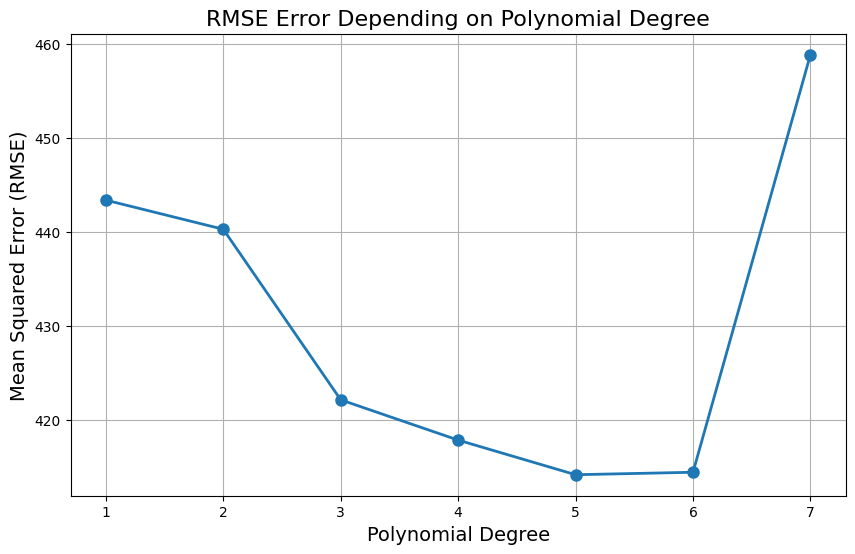

In [66]:
model = LinearRegression()

degrees = range(1, 8)
errors = []

for degree in degrees:
    X_train_expanded = X_train.copy()
    X_test_expanded = X_test.copy()

    for d in range(2, degree + 1):
        X_train_expanded = pd.concat([X_train_expanded, X_train ** d], axis=1)
        X_test_expanded = pd.concat([X_test_expanded, X_test ** d], axis=1)

    X_train_scaled = scaler.fit_transform(X_train_expanded)
    X_test_scaled = scaler.transform(X_test_expanded)

    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    mse = sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    in_margin = calculate_percentage_within_margin(y_test,y_pred)

    errors.append((degree, mse, r2, in_margin))

print(f"{'Degree':<10}{'RMSE':<20}{'R^2':<20}{'Within_Margin':<20}")
for degree, mse, r2, in_margin in errors:
    print(f"{degree:<10}{mse:<20.4f}{r2:<20.4f}{in_margin}")

mse_values = [error[1] for error in errors]
plt.figure(figsize=(10, 6))
plt.plot(degrees, mse_values, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.title("RMSE Error Depending on Polynomial Degree", fontsize=16)
plt.xlabel("Polynomial Degree", fontsize=14)
plt.ylabel("Mean Squared Error (RMSE)", fontsize=14)
plt.grid(True)
plt.xticks(degrees)
plt.show()

Despite being significantly more complex than the simple multiple regression model, the polynomial regression model did not perform clearly better. The R² metric results were slightly better than those of the basic linear model, but our margin error metric showed a decreasing percentage of predictions falling within the acceptable error range as the polynomial degree increased. For higher polynomial degrees (above 6), there was a significant increase in the test error.

Due to these issues, we discarded models using polynomial features as ineffective and difficult to interpret.

## 2. Determining the Most Important Features Using a Greedy Algorithm

1 feature: ['Geek_square'], R^2 train: 0.6357, R^2 test: 0.6352
2 feature: ['Geek_square', 'Avg_Rating_x_Rating_Geek'], R^2 train: 0.6799, R^2 test: 0.6793
3 feature: ['Geek_square', 'Avg_Rating_x_Rating_Geek', 'Avg rating'], R^2 train: 0.7960, R^2 test: 0.7946
4 feature: ['Geek_square', 'Avg_Rating_x_Rating_Geek', 'Avg rating', 'Avg_Rating_square'], R^2 train: 0.8161, R^2 test: 0.8148
5 feature: ['Geek_square', 'Avg_Rating_x_Rating_Geek', 'Avg rating', 'Avg_Rating_square', 'Geek Rating'], R^2 train: 0.8248, R^2 test: 0.8236
6 feature: ['Geek_square', 'Avg_Rating_x_Rating_Geek', 'Avg rating', 'Avg_Rating_square', 'Geek Rating', 'Type 1_Party'], R^2 train: 0.8264, R^2 test: 0.8251
7 feature: ['Geek_square', 'Avg_Rating_x_Rating_Geek', 'Avg rating', 'Avg_Rating_square', 'Geek Rating', 'Type 1_Party', 'Type 1_Strategy'], R^2 train: 0.8276, R^2 test: 0.8263
8 feature: ['Geek_square', 'Avg_Rating_x_Rating_Geek', 'Avg rating', 'Avg_Rating_square', 'Geek Rating', 'Type 1_Party', 'Type 1_Strat

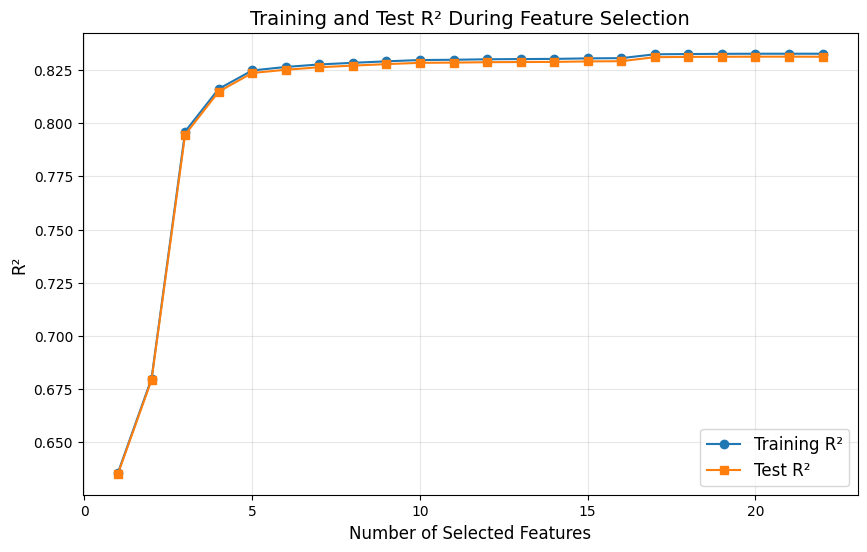

In [67]:
features = list(X_train.columns)

selected_features = []
remaining_features = features.copy()
train_r2_scores = []
test_r2_scores = []
feature_sets = []


lr = LinearRegression()

while remaining_features:
    scores_train = []
    scores_test = []

    for feature in remaining_features:
        current_features = selected_features + [feature]

        cv_results = cross_validate(
            lr, X_train[current_features], y_train, cv=5, scoring='r2', return_train_score=True
        )

        mean_train_r2 = np.mean(cv_results['train_score'])
        mean_test_r2 = np.mean(cv_results['test_score'])

        scores_train.append(mean_train_r2)
        scores_test.append(mean_test_r2)

    max_test_r2 = max(scores_test)
    best_feature = remaining_features[scores_test.index(max_test_r2)]

    selected_features.append(best_feature)
    remaining_features.remove(best_feature)

    train_r2_scores.append(scores_train[scores_test.index(max_test_r2)])
    test_r2_scores.append(max_test_r2)
    feature_sets.append(selected_features.copy())

for i, (features_set, train_r2, test_r2) in enumerate(zip(feature_sets, train_r2_scores, test_r2_scores)):
    print(f"{i+1} feature: {features_set}, R^2 train: {train_r2:.4f}, R^2 test: {test_r2:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_r2_scores) + 1), train_r2_scores, marker='o', label='Training R²')
plt.plot(range(1, len(test_r2_scores) + 1), test_r2_scores, marker='s', label='Test R²')

plt.title('Training and Test R² During Feature Selection', fontsize=14)
plt.xlabel('Number of Selected Features', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.show()

Using the step-wise method with cross-validation, we selected the most important features for predicting our data. As shown above, both the training and test sets achieved nearly identical R² scores for the selected feature set. Similar to the simple linear model, the most important feature turned out to be Geek_square. All of the top 5 most important features are directly related to the original 'Geek Rating' and 'Avg Rating' features. The last place in the ranking was taken by 'Max time'.

Since none of the features worsened the R² score for the test data, we decided not to discard any of the features.

## 3. Tree-Based Models

We decided to measure the effectiveness of predicting our target value using a decision tree and a random forest model. Since the random forest can take a random subset of features to build its trees, we decided to check if there would be significant differences between selecting all features (the default option) and using only half of them.

In [68]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

tree_model = DecisionTreeRegressor(max_depth=50, random_state=42)
tree_model.fit(X_train, y_train)
y_tree_pred = tree_model.predict(X_test)

forest_model1 = RandomForestRegressor(n_estimators=100,  random_state=42)
forest_model1.fit(X_train, y_train)
y_forest_pred1 = forest_model1.predict(X_test)

forest_model2 = RandomForestRegressor(n_estimators=100, max_features=0.5, random_state=42)
forest_model2.fit(X_train, y_train)
y_forest_pred2 = forest_model2.predict(X_test)

mse_tree = mean_squared_error(y_test, y_tree_pred)
rmse_tree = sqrt(mse_tree)
mse_forest1 = mean_squared_error(y_test, y_forest_pred1)
rmse_forest1 = sqrt(mse_forest1)
mse_forest2 = mean_squared_error(y_test, y_forest_pred2)
rmse_forest2 = sqrt(mse_forest2)
r2_tree = r2_score(y_test, y_tree_pred)
r2_forest1 = r2_score(y_test, y_forest_pred1)
r2_forest2 = r2_score(y_test, y_forest_pred2)

print("RMSE (Decision Tree):", rmse_tree)
print("R² (Decision Tree):", r2_tree)
print("Percentage of predictions within 10% margin (Decision Tree):", calculate_percentage_within_margin(y_test, y_tree_pred))
print("RMSE (Random Forest with all features):", rmse_forest1)
print("R² (Random Forest with all features):", r2_forest1)
print("Percentage of predictions within 10% margin (Random Forest with all features):", calculate_percentage_within_margin(y_test, y_forest_pred1))
print("RMSE (Random Forest with part of the features):", rmse_forest2)
print("R² (Random Forest with part of the features):", r2_forest2)
print("Percentage of predictions within 10% margin (Random Forest with part of the features):", calculate_percentage_within_margin(y_test, y_forest_pred2))

RMSE (Decision Tree): 330.39089832655907
R² (Decision Tree): 0.9013287460981865
Percentage of predictions within 10% margin (Decision Tree): 41.95%
RMSE (Random Forest with all features): 232.2954016060099
R² (Random Forest with all features): 0.9512229283996967
Percentage of predictions within 10% margin (Random Forest with all features): 49.82%
RMSE (Random Forest with part of the features): 238.651747616401
R² (Random Forest with part of the features): 0.9485170130880606
Percentage of predictions within 10% margin (Random Forest with part of the features): 49.5%


As seen above, the random forest using a subset of features yields results that are either identical to or worse than the random forest using all features. Therefore, we decided not to pursue this further. The decision tree also performs worse, but since this method is quite different from the random forest, we decided to continue exploring it.

In [69]:
feature_importance = tree_model.feature_importances_

for feature, importance in zip(X_train.columns, feature_importance):
    print(f"{feature}: {importance:.4f}")

Geek Rating: 0.6647
Avg rating: 0.1352
Year: 0.0039
Complexity: 0.0013
Min time: 0.0007
Max time: 0.0015
Age_category: 0.0006
Max_players_category: 0.0022
Min_players_category: 0.0003
Type 1_Children's: 0.0000
Type 1_Customizable: 0.0000
Type 1_Family: 0.0016
Type 1_Party: 0.0012
Type 1_Strategy: 0.0002
Type 1_Thematic: 0.0005
Type 1_Wargames: 0.0000
Geek_square: 0.0679
Complexity_square: 0.0018
Complexity_x_Geek_Rating: 0.0010
Avg_Rating_square: 0.1024
Avg_Rating_x_Rating_Geek: 0.0094
Max_Time_x_Complexity: 0.0037


In [70]:
forest_model = forest_model1
feature_importance = forest_model.feature_importances_

for feature, importance in zip(X_train.columns, feature_importance):
    print(f"{feature}: {importance:.4f}")


Geek Rating: 0.4011
Avg rating: 0.1189
Year: 0.0033
Complexity: 0.0020
Min time: 0.0017
Max time: 0.0015
Age_category: 0.0011
Max_players_category: 0.0026
Min_players_category: 0.0008
Type 1_Children's: 0.0001
Type 1_Customizable: 0.0001
Type 1_Family: 0.0015
Type 1_Party: 0.0010
Type 1_Strategy: 0.0002
Type 1_Thematic: 0.0005
Type 1_Wargames: 0.0000
Geek_square: 0.3398
Complexity_square: 0.0017
Complexity_x_Geek_Rating: 0.0018
Avg_Rating_square: 0.1091
Avg_Rating_x_Rating_Geek: 0.0069
Max_Time_x_Complexity: 0.0040


Regarding feature importance, for a single decision tree, it is clear that 'Geek Rating' is by far the most important feature. In second place, nearly six times less important, is 'Avg rating'.

In the case of the random forest, 'Geek Rating' is still the most important, but its importance measure decreased by about 1/3. Interestingly, in second place is the feature we created, 'Geek_square'. The difference in feature importance can be attributed to the fact that individual decision trees tend to overfit the training data, which may have influenced the importance of individual features.

Tree depth: 5
  Average RMSE (CV): 406.3858
  Average R^2 (CV): 0.8553
Tree depth: 10
  Average RMSE (CV): 315.2856
  Average R^2 (CV): 0.9123
Tree depth: 20
  Average RMSE (CV): 292.5865
  Average R^2 (CV): 0.9248
Tree depth: 25
  Average RMSE (CV): 294.2357
  Average R^2 (CV): 0.9241
Tree depth: 30
  Average RMSE (CV): 282.4468
  Average R^2 (CV): 0.9299
Tree depth: 35
  Average RMSE (CV): 309.8870
  Average R^2 (CV): 0.9164
Tree depth: 40
  Average RMSE (CV): 295.9767
  Average R^2 (CV): 0.9225
Tree depth: 45
  Average RMSE (CV): 324.9490
  Average R^2 (CV): 0.9079
Tree depth: 50
  Average RMSE (CV): 319.7394
  Average R^2 (CV): 0.9107
Tree depth: 55
  Average RMSE (CV): 319.7394
  Average R^2 (CV): 0.9107
Tree depth: 60
  Average RMSE (CV): 319.7394
  Average R^2 (CV): 0.9107
Tree depth: 80
  Average RMSE (CV): 319.7394
  Average R^2 (CV): 0.9107
Tree depth: 100
  Average RMSE (CV): 319.7394
  Average R^2 (CV): 0.9107

Best model:
  Tree depth: 30
  RMSE on the test set: 333.7100
 

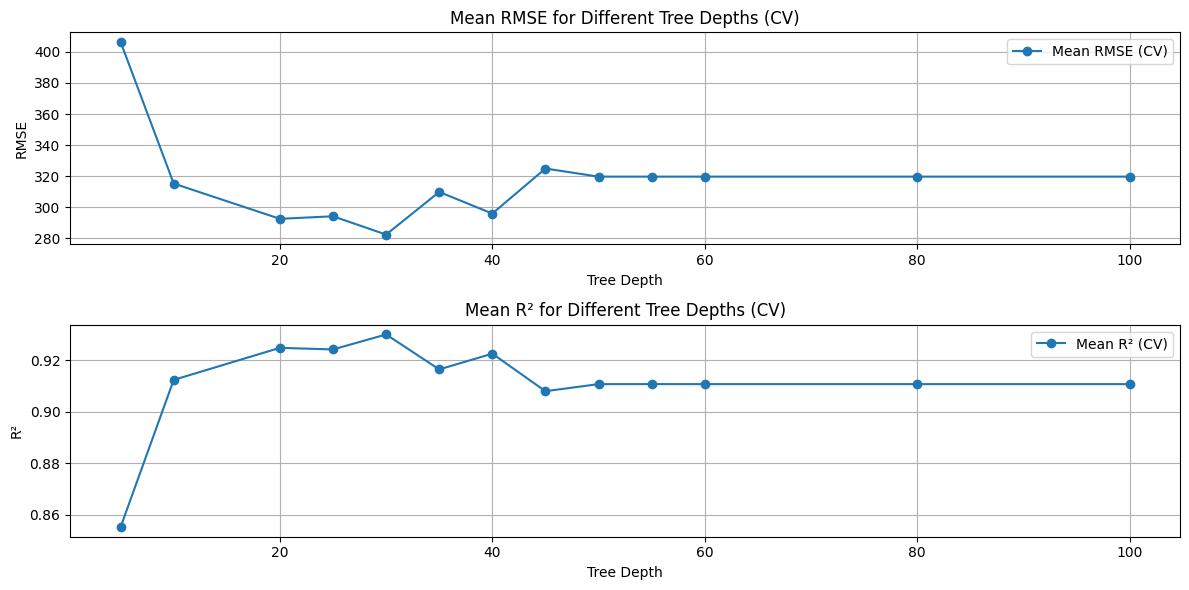

In [71]:
depths = [5, 10, 20, 25, 30, 35, 40, 45, 50, 55, 60, 80, 100]

cv_mean_rmse = []
cv_mean_r2 = []

best_model = None
best_score = float('-inf')
best_depth = None

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)

    neg_mse_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')

    mean_rmse = sqrt(-np.mean(neg_mse_scores))
    mean_r2 = np.mean(r2_scores)

    cv_mean_rmse.append(mean_rmse)
    cv_mean_r2.append(mean_r2)

    print(f"Tree depth: {depth}")
    print(f"  Average RMSE (CV): {mean_rmse:.4f}")
    print(f"  Average R^2 (CV): {mean_r2:.4f}")

    if mean_r2 > best_score:
        best_score = mean_r2
        best_depth = depth
        best_model = model

best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_margin_percentage = calculate_percentage_within_margin(y_test2, y_test_pred)

print("\nBest model:")
print(f"  Tree depth: {best_depth}")
print(f"  RMSE on the test set: {test_rmse:.4f}")
print(f"  R² on the test set: {test_r2:.4f}")
print(f"  Percentage of samples within margin (test): {test_margin_percentage}")

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(depths, cv_mean_rmse, label="Mean RMSE (CV)", marker="o")
plt.xlabel("Tree Depth")
plt.ylabel("RMSE")
plt.title("Mean RMSE for Different Tree Depths (CV)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(depths, cv_mean_r2, label="Mean R² (CV)", marker="o")
plt.xlabel("Tree Depth")
plt.ylabel("R²")
plt.title("Mean R² for Different Tree Depths (CV)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


As seen in the chart above, from around a depth of 50, the RMSE for the validation data stops changing with increasing tree depth, suggesting that at this depth, overfitting occurs.

Tree depth: 5
  Average RMSE (CV): 412.9251
  Average R^2 (CV): 0.8507
Tree depth: 10
  Average RMSE (CV): 296.1194
  Average R^2 (CV): 0.9226
Tree depth: 20
  Average RMSE (CV): 312.9542
  Average R^2 (CV): 0.9140
Tree depth: 25
  Average RMSE (CV): 323.8479
  Average R^2 (CV): 0.9066
Tree depth: 30
  Average RMSE (CV): 296.0602
  Average R^2 (CV): 0.9228
Tree depth: 35
  Average RMSE (CV): 314.3792
  Average R^2 (CV): 0.9135
Tree depth: 40
  Average RMSE (CV): 325.2883
  Average R^2 (CV): 0.9073
Tree depth: 45
  Average RMSE (CV): 291.8409
  Average R^2 (CV): 0.9254
Tree depth: 50
  Average RMSE (CV): 292.8559
  Average R^2 (CV): 0.9247
Tree depth: 55
  Average RMSE (CV): 292.8559
  Average R^2 (CV): 0.9247
Tree depth: 60
  Average RMSE (CV): 292.8559
  Average R^2 (CV): 0.9247
Tree depth: 80
  Average RMSE (CV): 292.8559
  Average R^2 (CV): 0.9247
Tree depth: 100
  Average RMSE (CV): 292.8559
  Average R^2 (CV): 0.9247

Best model:
  Tree depth: 45
  RMSE on the test set: 325.1036
 

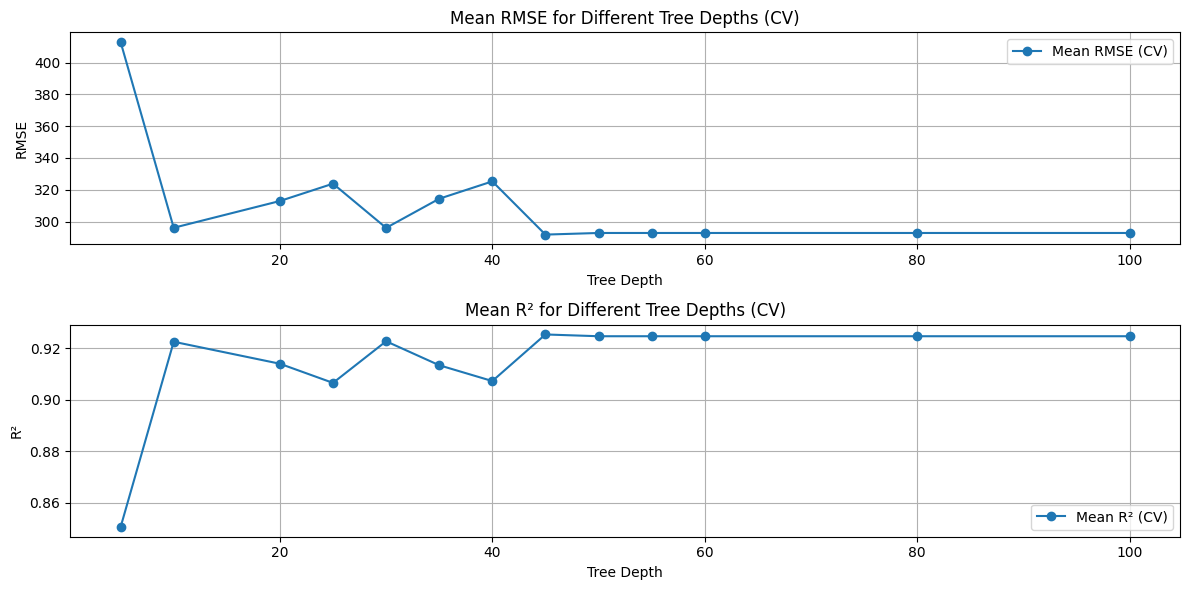

In [72]:
X_without_new_columns = data_without_new_columns.drop(columns=['Num of voters'])
y_without_new_columns = data_without_new_columns['Num of voters']
X_train2, X_test2, y_train2, y_test2 = train_test_split(
    X_without_new_columns, y_without_new_columns, test_size=0.2, random_state=2137
)

depths = [5, 10, 20, 25, 30, 35, 40, 45, 50,  55, 60, 80, 100]

cv_mean_rmse = []
cv_mean_r2 = []

best_model = None
best_score = float('-inf')
best_depth = None

for depth in depths:
    model = DecisionTreeRegressor(max_depth=depth, random_state=42)

    neg_mse_scores = cross_val_score(model, X_train2, y_train2, cv=5, scoring='neg_mean_squared_error')
    r2_scores = cross_val_score(model, X_train2, y_train2, cv=5, scoring='r2')

    mean_rmse = sqrt(-np.mean(neg_mse_scores))
    mean_r2 = np.mean(r2_scores)

    cv_mean_rmse.append(mean_rmse)
    cv_mean_r2.append(mean_r2)

    print(f"Tree depth: {depth}")
    print(f"  Average RMSE (CV): {mean_rmse:.4f}")
    print(f"  Average R^2 (CV): {mean_r2:.4f}")

    if mean_r2 > best_score:
        best_score = mean_r2
        best_depth = depth
        best_model = model

best_model.fit(X_train2, y_train2)

y_test_pred = best_model.predict(X_test2)
test_rmse = sqrt(mean_squared_error(y_test2, y_test_pred))
test_r2 = r2_score(y_test2, y_test_pred)

test_margin_percentage = calculate_percentage_within_margin(y_test2, y_test_pred)
print("\nBest model:")
print(f"  Tree depth: {best_depth}")
print(f"  RMSE on the test set: {test_rmse:.4f}")
print(f"  R² on the test set: {test_r2:.4f}")
print(f"  Percentage of samples within margin (test): {test_margin_percentage}")

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(depths, cv_mean_rmse, label="Mean RMSE (CV)", marker="o")
plt.xlabel("Tree Depth")
plt.ylabel("RMSE")
plt.title("Mean RMSE for Different Tree Depths (CV)")
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(depths, cv_mean_r2, label="Mean R² (CV)", marker="o")
plt.xlabel("Tree Depth")
plt.ylabel("R²")
plt.title("Mean R² for Different Tree Depths (CV)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


We also examined how the creation of tree-based regressors performs without using the features we created. Contrary to our expectations, the results were not identical — the achieved error was lower and occurred for a shallower tree. However, overfitting appeared at a similar depth.

We also used a random forest for regression. We chose 200 estimators due to the time constraints and the fact that increasing the number of trees beyond this point did not significantly improve the model.

In [73]:
from sklearn.ensemble import RandomForestRegressor

forest_model = RandomForestRegressor(n_estimators=200,  random_state=42)
forest_model.fit(X_train, y_train)
y_forest_pred = forest_model.predict(X_test)

mse_forest = mean_squared_error(y_test, y_forest_pred)
r2_forest = r2_score(y_test, y_forest_pred)
rmse_forest = sqrt(mse_forest)

print("RMSE (Random Forest):", rmse_forest)
print("R^2 (Random Forest):", r2_forest)
print("Percentage of predictions within 10% margin (Random Forest):", calculate_percentage_within_margin(y_test, y_forest_pred))


forest_feature_importance = forest_model.feature_importances_
print("Feature Importance:")
for feature, importance in zip(X_train.columns, forest_feature_importance):
    print(f"  {feature}: {importance:.4f}")


RMSE (Random Forest): 231.97995829206556
R^2 (Random Forest): 0.9513553111683253
Percentage of predictions within 10% margin (Random Forest): 49.9%
Feature Importance:
  Geek Rating: 0.3779
  Avg rating: 0.1161
  Year: 0.0035
  Complexity: 0.0018
  Min time: 0.0017
  Max time: 0.0013
  Age_category: 0.0012
  Max_players_category: 0.0027
  Min_players_category: 0.0009
  Type 1_Children's: 0.0001
  Type 1_Customizable: 0.0001
  Type 1_Family: 0.0015
  Type 1_Party: 0.0010
  Type 1_Strategy: 0.0002
  Type 1_Thematic: 0.0005
  Type 1_Wargames: 0.0000
  Geek_square: 0.3629
  Complexity_square: 0.0018
  Complexity_x_Geek_Rating: 0.0017
  Avg_Rating_square: 0.1120
  Avg_Rating_x_Rating_Geek: 0.0072
  Max_Time_x_Complexity: 0.0039


Since the random forest, without a specified max_depth parameter, sets the depth dynamically, we also tested creating forests with manually set depths.

Random Forest - Depth: 5, number of estimators: 200
  Average R^2: 0.9148
Random Forest - Depth: 10, number of estimators: 200
  Average R^2: 0.9557
Random Forest - Depth: 20, number of estimators: 200
  Average R^2: 0.9571
Random Forest - Depth: 30, number of estimators: 200
  Average R^2: 0.9574
Random Forest - Depth: 35, number of estimators: 200
  Average R^2: 0.9572
Random Forest - Depth: 40, number of estimators: 200
  Average R^2: 0.9570
Random Forest - Depth: 45, number of estimators: 200
  Average R^2: 0.9571
Random Forest - Depth: 50, number of estimators: 200
  Average R^2: 0.9571
Random Forest - Depth: 60, number of estimators: 200
  Average R^2: 0.9571
Random Forest - Depth: 80, number of estimators: 200
  Average R^2: 0.9571

Best model:
  Tree depth: 30
  RMSE on the test set: 233.1155
  R² on the test set: 0.9509
  Percentage of samples within margin (test): 49.95%
Most important features of the best Random Forest model:
  Geek Rating: 0.3797
  Avg rating: 0.1127
  Year

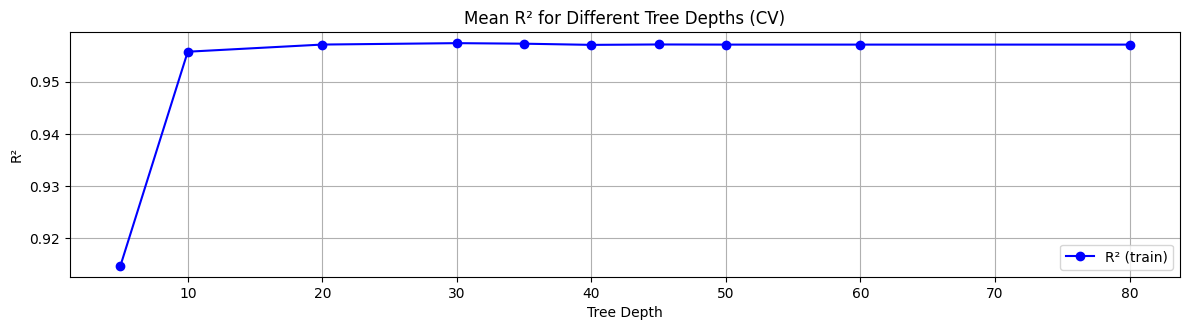

In [74]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np

depths_rf = [5, 10, 20, 30, 35, 40, 45, 50, 60, 80]
n_estimators = 200

cv_train_r2 = []

best_model = None
best_depth = None
best_train_r2 = float('-inf')

for depth in depths_rf:
    rf_model = RandomForestRegressor(max_depth=depth, n_estimators=n_estimators, random_state=42)

    train_r2_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='r2')

    mean_r2 = np.mean(train_r2_scores)

    cv_train_r2.append(mean_r2)

    print(f"Random Forest - Depth: {depth}, number of estimators: {n_estimators}")
    print(f"  Average R^2: {mean_r2:.4f}")

    if mean_r2 > best_train_r2:
        best_train_r2 = mean_r2
        best_depth = depth
        best_model = rf_model

best_forest = best_model # na pozniej do uzycia

best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_margin_percentage = calculate_percentage_within_margin(y_test, y_test_pred)
print("\nBest model:")
print(f"  Tree depth: {best_depth}")
print(f"  RMSE on the test set: {test_rmse:.4f}")
print(f"  R² on the test set: {test_r2:.4f}")
print(f"  Percentage of samples within margin (test): {test_margin_percentage}")

if hasattr(best_model, "feature_importances_"):
    boost_feature_importance = best_model.feature_importances_
    print("Most important features of the best Random Forest model:")
    for feature, importance in zip(X_train.columns, boost_feature_importance):
        print(f"  {feature}: {importance:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(depths_rf, cv_train_r2, label="R² (train)", marker="o", color="blue")
plt.xlabel("Tree Depth")
plt.ylabel("R²")
plt.title("Mean R² for Different Tree Depths (CV)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()



Comparing the results, it can be observed that for the best regressor with a fixed tree depth of 30, slightly better predictions were achieved within the 10% margin, while slightly worse results were observed for the RMSE compared to the random forest with a dynamically determined depth.

As seen in the chart, R² initially rises sharply and then stabilizes with minimal fluctuations. Starting from a depth of 40, we observe the error stabilizing, with R² remaining unchanged until the end of the examined range.

### 3.1 Bagging


As part of tree-based models, we also attempted to build a BaggingRegressor based on decision trees, with the assumption that by using a large number of tree regressors trained on random samples from the Train set, we would achieve similar results.

Bagging - Tree depth: 5, Number of estimators: 200
  Średni R^2: 0.9163
Bagging - Tree depth: 10, Number of estimators: 200
  Średni R^2: 0.9519
Bagging - Tree depth: 20, Number of estimators: 200
  Średni R^2: 0.9533
Bagging - Tree depth: 30, Number of estimators: 200
  Średni R^2: 0.9533
Bagging - Tree depth: 35, Number of estimators: 200
  Średni R^2: 0.9533
Bagging - Tree depth: 40, Number of estimators: 200
  Średni R^2: 0.9536
Bagging - Tree depth: 45, Number of estimators: 200
  Średni R^2: 0.9536
Bagging - Tree depth: 50, Number of estimators: 200
  Średni R^2: 0.9536
Bagging - Tree depth: 60, Number of estimators: 200
  Średni R^2: 0.9536
Bagging - Tree depth: 80, Number of estimators: 200
  Średni R^2: 0.9536

Best model:
  Tree depth: 45
  RMSE on the test set: 243.4640
  R² on the test set: 0.9464
  Percentage of samples within margin (test): 49.67%


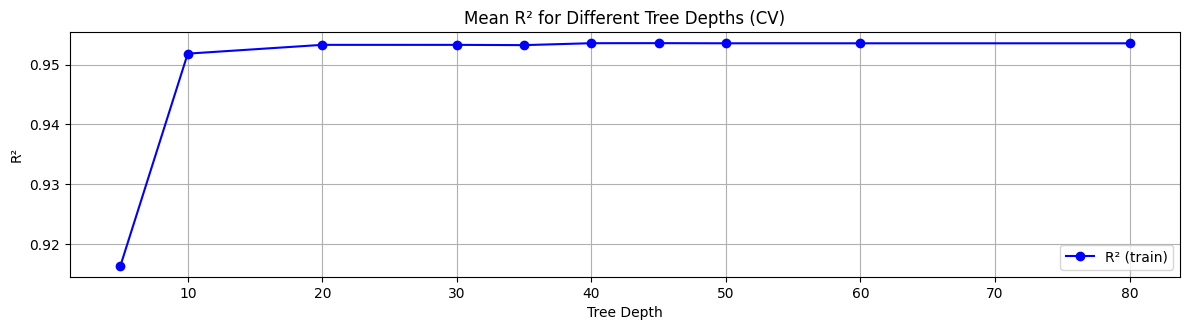

In [75]:
from sklearn.ensemble import BaggingRegressor
n_estimators = 200

cv_train_r2 = []

best_model = None
best_depth = None
best_train_r2 = float('-inf')

for max_depth in depths_rf:
    base_model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)

    bagging_model = BaggingRegressor(
        estimator=base_model,
        n_estimators=n_estimators,
        bootstrap=True,
        random_state=42,
        max_samples=0.5,
        n_jobs=-1
    )

    train_r2_scores = cross_val_score(bagging_model, X_train, y_train, cv=5, scoring='r2')

    mean_r2 = np.mean(train_r2_scores)

    cv_train_r2.append(mean_r2)

    print(f"Bagging - Tree depth: {max_depth}, Number of estimators: {n_estimators}")
    print(f"  Średni R^2: {mean_r2:.4f}")

    if mean_r2 > best_train_r2:
        best_train_r2 = mean_r2
        best_depth = max_depth
        best_model = bagging_model


best_model.fit(X_train, y_train)

y_test_pred = best_model.predict(X_test)
test_rmse = sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)
test_margin_percentage = calculate_percentage_within_margin(y_test, y_test_pred)

print("\nBest model:")
print(f"  Tree depth: {best_depth}")
print(f"  RMSE on the test set: {test_rmse:.4f}")
print(f"  R² on the test set: {test_r2:.4f}")
print(f"  Percentage of samples within margin (test): {test_margin_percentage}")

if hasattr(best_model, "feature_importances_"):
    boost_feature_importance = best_model.feature_importances_
    print("Most important features of the best Bagging model:")
    for feature, importance in zip(X_train.columns, boost_feature_importance):
        print(f"  {feature}: {importance:.4f}")

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(depths_rf, cv_train_r2, label="R² (train)", marker="o", color="blue")
plt.xlabel("Tree Depth")
plt.ylabel("R²")
plt.title("Mean R² for Different Tree Depths (CV)")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


Despite the similar functionality, the Bagging model achieved slightly worse results in cross-validation (CV) when measured with the R^2 metric compared to random forests. The model reached a high R^2 even with a tree depth of 10, and further small improvements were observed up to a depth of around 45-50. After that, the error stabilized, reaching its lowest value.

The optimal tree depth turned out to be 45; the trained model with this parameter on the entire training set achieved prediction accuracy within the margin that was about 0.3 percentage points worse than the best random forest. This result might be due to differences in the implementation between the random forest we recreated and the actual RandomForestRegressor algorithm.

### 3.2 Boosting


To test the performance of boosting models, you tried AdaBoost, GradientBoostingRegressor, and XGBRegressor with a fixed number of estimators based on previous experiments using cross-validation.

In [76]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import matplotlib.pyplot as plt

ada_boost_model = AdaBoostRegressor(
    n_estimators=500,
    learning_rate=0.01,
    random_state=42
)

ada_boost_model.fit(X_train, y_train)

y_ada_pred = ada_boost_model.predict(X_test)

mse_ada = mean_squared_error(y_test, y_ada_pred)
r2_ada = r2_score(y_test, y_ada_pred)
rmse_boost = sqrt(mse_ada)
percentage_in_margin = calculate_percentage_within_margin(y_test, y_ada_pred)

print("AdaBoost Regressor:")
print(f"  RMSE: {rmse_boost:.4f}")
print(f"  R^2: {r2_ada:.4f}")
print(f"Percentage of predictions within 10% margin: {percentage_in_margin}")

if hasattr(ada_boost_model, "feature_importances_"):
    boost_feature_importance = ada_boost_model.feature_importances_
    print("Feature Importance (AdaBoost):")
    for feature, importance in zip(X_train.columns, boost_feature_importance):
        print(f"  {feature}: {importance:.4f}")


AdaBoost Regressor:
  RMSE: 475.7789
  R^2: 0.7954
Percentage of predictions within 10% margin: 7.1%
Feature Importance (AdaBoost):
  Geek Rating: 0.3630
  Avg rating: 0.0803
  Year: 0.0399
  Complexity: 0.0027
  Min time: 0.0148
  Max time: 0.0023
  Age_category: 0.0005
  Max_players_category: 0.0104
  Min_players_category: 0.0000
  Type 1_Children's: 0.0000
  Type 1_Customizable: 0.0000
  Type 1_Family: 0.0038
  Type 1_Party: 0.0132
  Type 1_Strategy: 0.0000
  Type 1_Thematic: 0.0000
  Type 1_Wargames: 0.0000
  Geek_square: 0.3758
  Complexity_square: 0.0024
  Complexity_x_Geek_Rating: 0.0008
  Avg_Rating_square: 0.0851
  Avg_Rating_x_Rating_Geek: 0.0000
  Max_Time_x_Complexity: 0.0050


It's clear from your analysis that AdaBoost did not perform well in predicting the target variable within the acceptable margin of error. The results, with over 13% margin of error for the linear model versus 7.1% for AdaBoost, suggest that AdaBoost struggled with the complexity of the data, possibly due to its reliance on weak learners (typically shallow trees). This could indicate that AdaBoost had difficulty capturing the intricate patterns in your dataset, especially if there were more complex interactions between the features.

In [77]:
from sklearn.ensemble import GradientBoostingRegressor

gradient_boosting = GradientBoostingRegressor(
    n_estimators=500,
    max_depth=5,
    random_state=42
)
gradient_boosting.fit(X_train, y_train)

y_boost_pred = gradient_boosting.predict(X_test)

mse_boost = mean_squared_error(y_test, y_boost_pred)
r2_boost = r2_score(y_test, y_boost_pred)
rmse_boost = sqrt(mse_boost)
percentage_in_margin = calculate_percentage_within_margin(y_test, y_boost_pred)

print("Gradient Boosting:")
print(f"  RMSE: {rmse_boost:.4f}")
print(f"  R^2: {r2_boost:.4f}")
print(f"Percentage of predictions within 10% margin: {percentage_in_margin}")

boost_feature_importance = gradient_boosting.feature_importances_
print("Feature Importance (Boosting):")
for feature, importance in zip(X_train.columns, boost_feature_importance):
    print(f"  {feature}: {importance:.4f}")

best_model_boosting = gradient_boosting

Gradient Boosting:
  RMSE: 226.2725
  R^2: 0.9537
Percentage of predictions within 10% margin: 47.28%
Feature Importance (Boosting):
  Geek Rating: 0.2998
  Avg rating: 0.1284
  Year: 0.0023
  Complexity: 0.0004
  Min time: 0.0008
  Max time: 0.0004
  Age_category: 0.0004
  Max_players_category: 0.0009
  Min_players_category: 0.0006
  Type 1_Children's: 0.0000
  Type 1_Customizable: 0.0001
  Type 1_Family: 0.0013
  Type 1_Party: 0.0012
  Type 1_Strategy: 0.0002
  Type 1_Thematic: 0.0005
  Type 1_Wargames: 0.0000
  Geek_square: 0.4376
  Complexity_square: 0.0004
  Complexity_x_Geek_Rating: 0.0012
  Avg_Rating_square: 0.1176
  Avg_Rating_x_Rating_Geek: 0.0035
  Max_Time_x_Complexity: 0.0026


The GradientBoostingRegressor model achieved very good results in three key metrics: RMSE, the number of predictions within the tolerance margin, and R². Particularly for the R² metric, it achieved the best result among the tested models. The model gave the most weight to the Geek Rating and Avg Rating features, while other features were largely ignored. The best results were obtained with a tree depth of 5, as other values of this parameter led to worse outcomes.

In [78]:
from xgboost import XGBRegressor

xgbossting = XGBRegressor(
    random_state=42,
    max_depth=5,
    n_estimators=500
)

xgbossting.fit(X_train, y_train)

y_boost_pred = xgbossting.predict(X_test)

mse_boost = mean_squared_error(y_test, y_boost_pred)
r2_boost = r2_score(y_test, y_boost_pred)
rmse_boost = sqrt(mse_boost)
percentage_in_margin = calculate_percentage_within_margin(y_test, y_boost_pred)

print("XGBoost:")
print(f"  RMSE: {rmse_boost:.4f}")
print(f"  R^2: {r2_boost:.4f}")
print(f"Percentage of predictions within 10% margin: {percentage_in_margin}")

boost_feature_importance = xgbossting.feature_importances_
print("Feature Importance (XGBoost):")
for feature, importance in zip(X_train.columns, boost_feature_importance):
    print(f"  {feature}: {importance:.4f}")


XGBoost:
  RMSE: 235.0907
  R^2: 0.9500
Percentage of predictions within 10% margin: 44.79%
Feature Importance (XGBoost):
  Geek Rating: 0.6303
  Avg rating: 0.2614
  Year: 0.0070
  Complexity: 0.0070
  Min time: 0.0060
  Max time: 0.0061
  Age_category: 0.0035
  Max_players_category: 0.0075
  Min_players_category: 0.0042
  Type 1_Children's: 0.0028
  Type 1_Customizable: 0.0043
  Type 1_Family: 0.0150
  Type 1_Party: 0.0163
  Type 1_Strategy: 0.0038
  Type 1_Thematic: 0.0091
  Type 1_Wargames: 0.0013
  Geek_square: 0.0000
  Complexity_square: 0.0000
  Complexity_x_Geek_Rating: 0.0033
  Avg_Rating_square: 0.0000
  Avg_Rating_x_Rating_Geek: 0.0045
  Max_Time_x_Complexity: 0.0064


The XGBRegressor behaves in a very similar way to the GradientBoostingRegressor, but the results obtained are slightly worse than those of the previous model. This model gave more attention to the other features, with Geek Rating and Avg Rating combined accounting for just over 89%.

From the comparison between the results of the GradientBoostingRegressor and XGBRegressor, it can be concluded that increasing the model's reliance on less significant features worsens its ability to make accurate predictions.

## 4. Regularization

When testing regularization methods, we applied MinMaxScaler in both cases and conducted tests on the training set using Cross Validation. The first method we tested was the Ridge method.

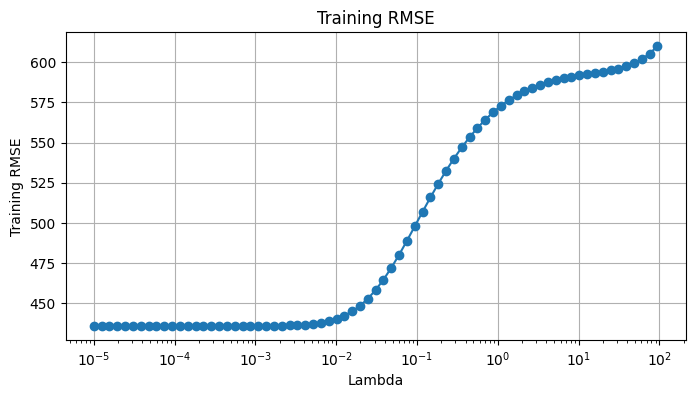

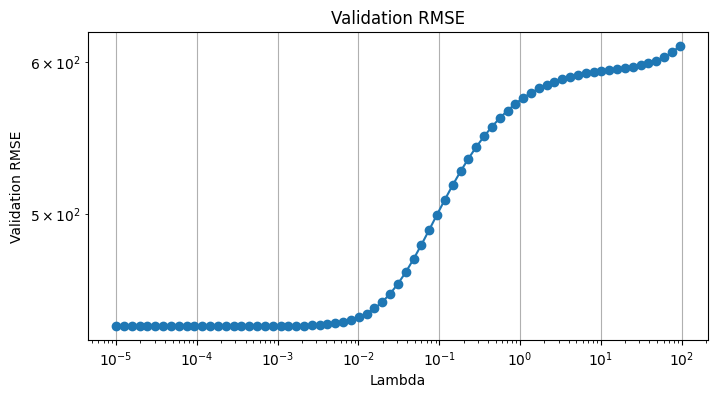

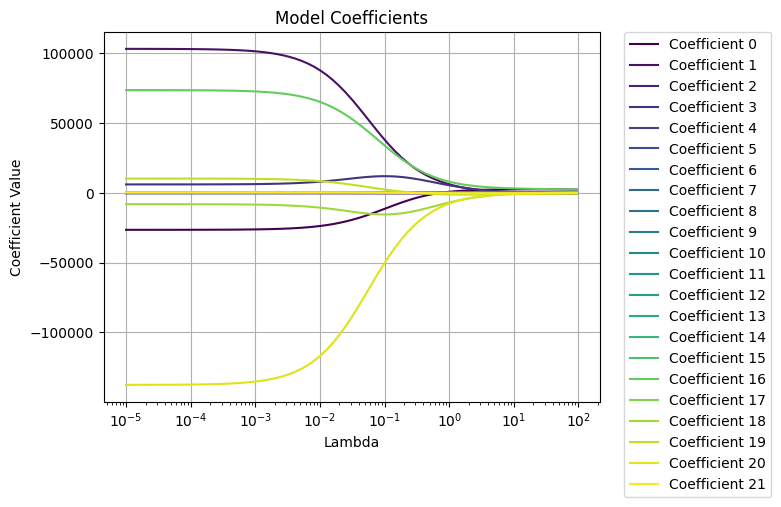

In [79]:
from sklearn.linear_model import Ridge
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2137)
bias, val, coeffs = [], [], []

lambdas = []
lamb = 0.00001
while lamb <= 100:
    lambdas.append(lamb)
    lamb *= 1.25

for lamb in lambdas:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('ridge', Ridge(alpha=lamb))
    ])

    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    bias.append(sqrt(-np.mean(scores['train_score'])))
    val.append(sqrt(-np.mean(scores['test_score'])))

    pipeline.fit(X_train, y_train)
    ridge_model = pipeline.named_steps['ridge']
    coefficients = ridge_model.coef_
    intercept = ridge_model.intercept_

    coeffs.append(coefficients)
plt.figure(figsize=(8, 4))
plt.plot(lambdas, bias, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Training RMSE')
plt.title('Training RMSE')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(lambdas, val, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Lambda')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE')
plt.grid(True)
plt.show()

from matplotlib.colors import ListedColormap
coeffs = np.array(coeffs)
colors = ListedColormap(plt.cm.viridis(np.linspace(0, 1, coeffs.shape[1])))
for i in range(coeffs.shape[1]):
    plt.plot(lambdas, coeffs[:, i], label=f'Coefficient {i}', color=colors(i))

plt.title('Model Coefficients')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()


In [80]:
feature_names = X_train.columns
coeffs = np.array(coeffs)
for i, feature in enumerate(feature_names):
    print(f"Coefficient: {i}: {feature}")

Coefficient: 0: Geek Rating
Coefficient: 1: Avg rating
Coefficient: 2: Year
Coefficient: 3: Complexity
Coefficient: 4: Min time
Coefficient: 5: Max time
Coefficient: 6: Age_category
Coefficient: 7: Max_players_category
Coefficient: 8: Min_players_category
Coefficient: 9: Type 1_Children's
Coefficient: 10: Type 1_Customizable
Coefficient: 11: Type 1_Family
Coefficient: 12: Type 1_Party
Coefficient: 13: Type 1_Strategy
Coefficient: 14: Type 1_Thematic
Coefficient: 15: Type 1_Wargames
Coefficient: 16: Geek_square
Coefficient: 17: Complexity_square
Coefficient: 18: Complexity_x_Geek_Rating
Coefficient: 19: Avg_Rating_square
Coefficient: 20: Avg_Rating_x_Rating_Geek
Coefficient: 21: Max_Time_x_Complexity


We increased the Lambda parameter by 20%, starting from a value of 1/100000 until we reached values where the error increased significantly. Further increases in the parameter were deemed unnecessary. The best results on both the training and test sets were achieved for very small lambdas, where regularization had practically no effect on the model. As expected, based on feature importance analysis from other models, increasing the lambda parameter started reducing the coefficients of key features (those with the largest coefficients in the non-regularized model). However, for high lambda values, where the error was already very large, the largest coefficients were assigned to features that were not significant in the non-regularized model.

Next, we tested the Lasso method:

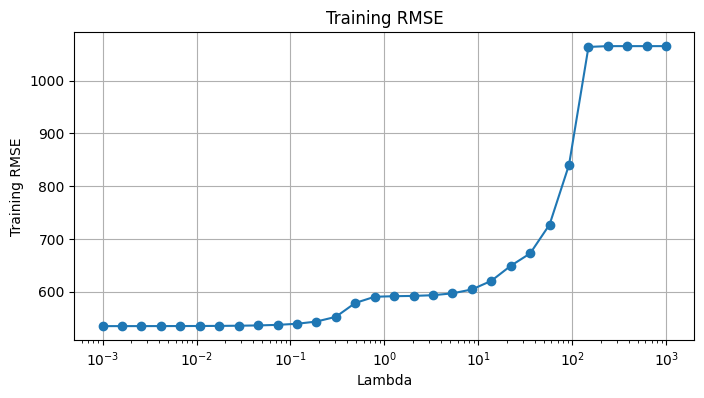

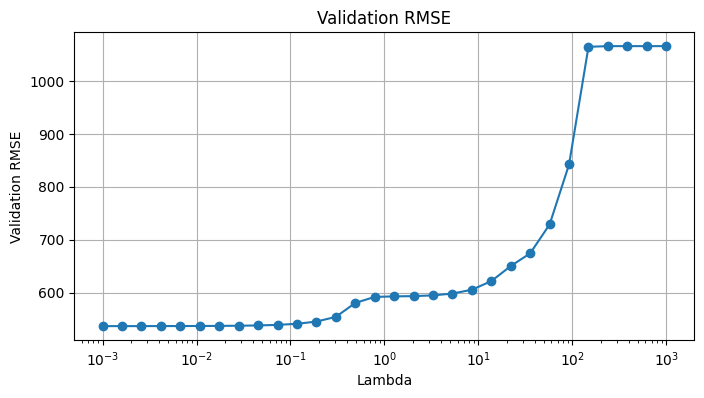

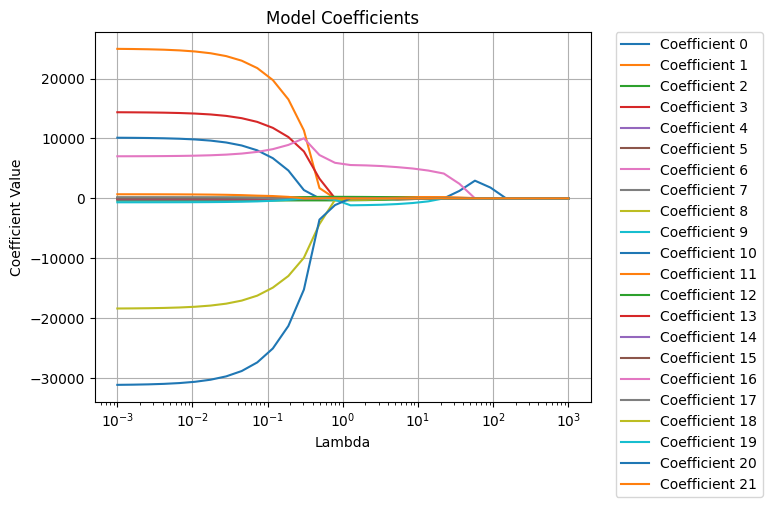

In [81]:
from sklearn.linear_model import Lasso

bias, val, coeffs, intercept = [], [], [], []

lambdas = np.logspace(-3, 3, num=30)

for lamb in lambdas:
    pipeline = Pipeline([
        ('scaler', MinMaxScaler()),
        ('lasso', Lasso(alpha=lamb, max_iter=1000, tol=1e-4))
    ])

    scores = cross_validate(pipeline, X_train, y_train, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
    bias.append(sqrt(-np.mean(scores['train_score'])))
    val.append(sqrt(-np.mean(scores['test_score'])))

    pipeline.fit(X_train, y_train)
    coeffs.append(pipeline.named_steps['lasso'].coef_)
    intercept.append(pipeline.named_steps['lasso'].intercept_)
plt.figure(figsize=(8, 4))
plt.plot(lambdas, bias, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Training RMSE')
plt.title('Training RMSE')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(lambdas, val, marker='o')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE')
plt.grid(True)
plt.show()

coeffs = np.array(coeffs)
for i in range(coeffs.shape[1]):
    plt.plot(lambdas, coeffs[:, i], label=f'Coefficient {i}')
plt.title('Model Coefficients')
plt.xscale('log')
plt.xlabel('Lambda')
plt.ylabel('Coefficient Value')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(True)
plt.show()




The model using the Lasso method returned results similar to those of the Ridge method. Despite applying a wide range of Lambdas, each increase in this parameter led to an increase in the model's error, both for the training and test sets. On the error plot, breakpoints are visible, but they do not affect the overall trend of increasing error with larger Lambdas. When the Lambda exceeded 10^2, all coefficients were set to zero, and the error stabilized at a very high level.

Analyzing both regularization methods, it is clear that they were completely ineffective. This is likely due to the large number of data points in the dataset and the relatively small number of features. The models are unable to fit every data point with such a large dataset, which naturally enforces generalization. In this case, overfitting does not occur, so regularization does not provide any benefits.

## 5. Polynomial Features

To check if any interesting feature relationships were overlooked, we tested creating polynomial features using PolynomialFeatures. This way, for degree 2, we get 275 features, and for degree 3, we get 2300 features.


Degree: 1
Root Mean Squared Error (RMSE): 443.3665
R² Score: 0.8223
R² Score: 13.09%

Best features and their coefficients:
Feature: Avg_Rating_x_Rating_Geek, Coefficient : -21755.5357
Feature: Avg rating, Coefficient : 16088.7097
Feature: Geek_square, Coefficient : 12465.1075
Feature: Geek Rating, Coefficient : -4575.1386
Feature: Avg_Rating_square, Coefficient : 1573.1351
Feature: Complexity_x_Geek_Rating, Coefficient : -1400.7843
Feature: Complexity, Coefficient : 1233.3342
Feature: Complexity_square, Coefficient : 72.3417
Feature: Max_Time_x_Complexity, Coefficient : 54.6347
Feature: Type 1_Party, Coefficient : 40.3855

Degree: 2
Root Mean Squared Error (RMSE): 295.7243
R² Score: 0.9209
R² Score: 20.26%

Best features and their coefficients:
Feature: Geek Rating Avg_Rating_square, Coefficient : -2198003.0601
Feature: Avg rating Avg_Rating_x_Rating_Geek, Coefficient : -2198003.0601
Feature: Avg_Rating_x_Rating_Geek^2, Coefficient : 1771204.4874
Feature: Geek_square Avg_Rating_squar

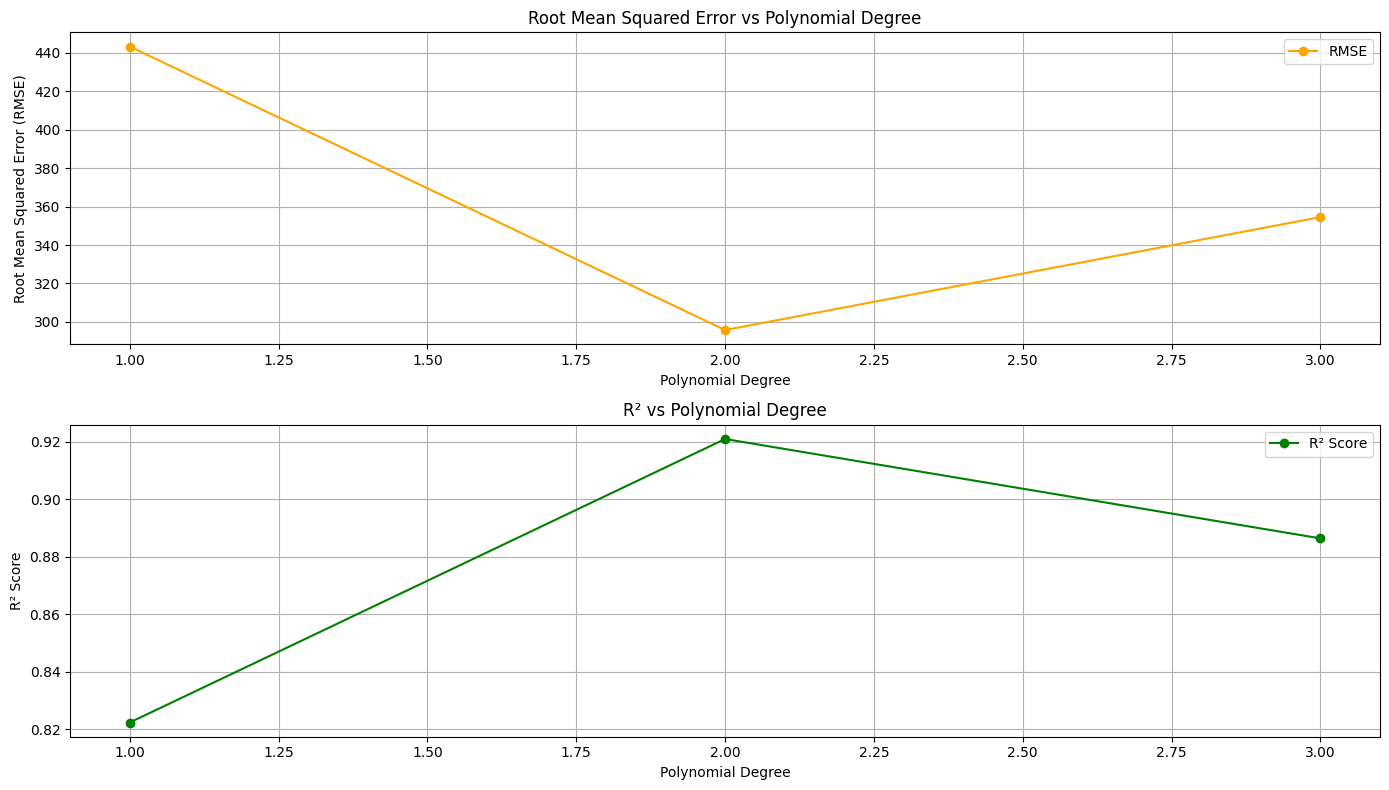

In [82]:
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

degrees = [1, 2, 3]
mean_errors = []
r2_scores = []
rmse_scores = []

margin = 0.1

for degree in degrees:
    print(f"\nDegree: {degree}")

    poly_features = PolynomialFeatures(degree=degree)
    X_train_poly = poly_features.fit_transform(X_train)
    feature_names = poly_features.get_feature_names_out(X_train.columns)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_poly)
    X_test_poly = poly_features.transform(X_test)
    X_test_scaled = scaler.transform(X_test_poly)

    regression = LinearRegression()
    regression.fit(X_train_scaled, y_train)

    y_pred = regression.predict(X_test_scaled)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mse)

    mean_errors.append(mse)
    r2_scores.append(r2)
    rmse_scores.append(rmse)

    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    print(f"R² Score: {calculate_percentage_within_margin(y_test, y_pred)}")

    coefficients = regression.coef_
    intercept = regression.intercept_
    print("\nBest features and their coefficients:")
    for name, coef in sorted(zip(feature_names, coefficients), key=lambda x: abs(x[1]), reverse=True)[:10]:
        print(f"Feature: {name}, Coefficient : {coef:.4f}")
plt.figure(figsize=(14, 8))

plt.subplot(2, 1, 1)
plt.plot(degrees, rmse_scores, marker='o', label='RMSE', color='orange')
plt.title('Root Mean Squared Error vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('Root Mean Squared Error (RMSE)')
plt.grid(True)
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(degrees, r2_scores, marker='o', label='R² Score', color='green')
plt.title('R² vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('R² Score')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()



Creating polynomial features significantly improved the results when using the basic LinearRegression model. For degree 2, the RMSE and R² metrics were much better than for degree 3, but degree 3 allowed for much better prediction of the number of observations within the specified margin of tolerance. For both degrees, the key features identified by the model were created from Geek Rating and Avg Rating. However, the large number of features made it difficult to conduct a deeper analysis of their individual impact on the model. Additionally, despite the use of complex and computationally expensive operations, models based on Polynomial Features were significantly worse than tree-based models. Attempting to create a random forest with Polynomial features failed, and for degree 2, the model became computationally expensive, with its performance dropping to the level of the LinearRegression model.

## 6. Experiment with the absence of 'Geek Rating'
Since all of our best models showed a significant dependence on the 'Geek Rating' feature (as per our hypothesis), we decided to test how the importance of selected features would change for the best random forest model after removing this feature.

In [83]:
X2 = X2.drop(columns=['Geek Rating'])
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.2, random_state=2137)

best_model = RandomForestRegressor(max_depth=30, n_estimators=200, random_state=42)
best_model.fit(X_train2, y_train2)

y_test_pred = best_model.predict(X_test2)

test_rmse = sqrt(mean_squared_error(y_test2, y_test_pred))
test_r2 = r2_score(y_test2, y_test_pred)

test_margin_percentage = calculate_percentage_within_margin(y_test2, y_test_pred)

print(f"  RMSE on the test set: {test_rmse:.4f}")
print(f"  R² on the test set: {test_r2:.4f}")
print(f"  Percentage of samples within margin (test): {test_margin_percentage}%")


forest_feature_importance = best_model.feature_importances_
print("Feature Importance:")
for feature, importance in zip(X_train2.columns, forest_feature_importance):
    print(f"  {feature}: {importance:.4f}")

  RMSE on the test set: 903.3382
  R² on the test set: 0.2624
  Percentage of samples within margin (test): 8.23%%
Feature Importance:
  Avg rating: 0.2408
  Year: 0.1383
  Complexity: 0.1534
  Min time: 0.0587
  Max time: 0.0582
  Age_category: 0.0425
  Max_players_category: 0.0549
  Min_players_category: 0.0344
  Type 1_Children's: 0.0038
  Type 1_Customizable: 0.0030
  Type 1_Family: 0.0903
  Type 1_Party: 0.0236
  Type 1_Strategy: 0.0713
  Type 1_Thematic: 0.0261
  Type 1_Wargames: 0.0008


As seen above, according to our assumptions, the most important feature in this situation turned out to be 'Avg rating'. The following features in order of importance were 'Complexity', 'Year', and 'Type 1_Family', achieving values of 0.1534, 0.1383, and 0.0903, respectively. The presence of 'Complexity' in second place is not surprising, as it was the third most correlated feature with 'Num of voters'.

As we can see, removing 'Geek Rating' significantly worsened all parameters of the regressor, making it nearly four times worse than the simplest linear model.

# Conclusion

We have two candidates for the best regression model, each achieving slightly better results in different aspects.

The smallest root mean square error (RMSE) was achieved by Gradient Boosting with a maximum tree depth of 5 and 500 estimators, using a dataset excluding our created features. Its RMSE was 225.9207, and R² was 0.9539. The percentage of predictions within a 10% margin was 47.18%.

The most important features for this model were 'Geek Rating', which appeared in some form in 74.22% of all tests. In second place was 'Avg rating' with 24.94%. Below, we provide the importance of all features and their modifications.

Geek Rating: 0.3840

Avg rating: 0.1135

Year: 0.0023

Complexity: 0.0004

Min time: 0.0008

Max time: 0.0004

Age_category: 0.0004

Max_players_category: 0.0009

Min_players_category: 0.0006

Type 1_Children's: 0.0000

Type 1_Customizable: 0.0001

Type 1_Family: 0.0013

Type 1_Party: 0.0012

Type 1_Strategy: 0.0002

Type 1_Thematic: 0.0005

Type 1_Wargames: 0.0000

Geek_square: 0.3533

Complexity_square: 0.0004

Complexity_x_Geek_Rating: 0.0012

Avg_Rating_square: 0.1322

Avg_Rating_x_Rating_Geek: 0.0037

Max_Time_x_Complexity: 0.0026



The highest percentage of predictions within the 10% margin of actual values was achieved by the Random Forest with 200 estimators and a depth of 30. The percentage within this margin was 49.95%. While the difference between its result and that of Gradient Boosting may seem small, in practice, most models performed at least 1 percentage point worse. RMSE was 233.1155, and R² was 0.9509, which gives a result about 3% worse than the one achieved by Gradient Boosting. Below is the feature importance for this model.

Geek Rating: 0.3797

Avg rating: 0.1127

Year: 0.0035

Complexity: 0.0018

Min time: 0.0019

Max time: 0.0015

Age_category: 0.0012

Max_players_category: 0.0026

Min_players_category: 0.0008

Type 1_Children's: 0.0001

Type 1_Customizable: 0.0001

Type 1_Family: 0.0015

Type 1_Party: 0.0009

Type 1_Strategy: 0.0002

Type 1_Thematic: 0.0005

Type 1_Wargames: 0.0000

Geek_square: 0.3612

Complexity_square: 0.0017

Complexity_x_Geek_Rating: 0.0018

Avg_Rating_square: 0.1146

Avg_Rating_x_Rating_Geek: 0.0079

Max_Time_x_Complexity: 0.0036


Just like with Gradient Boosting, 'Geek Rating' was the most important feature, appearing in some form in over 75% of the tests. The next most important feature was 'Avg rating' with nearly 24%. It's worth noting that the results for both models are almost identical, further emphasizing the importance of these two features.

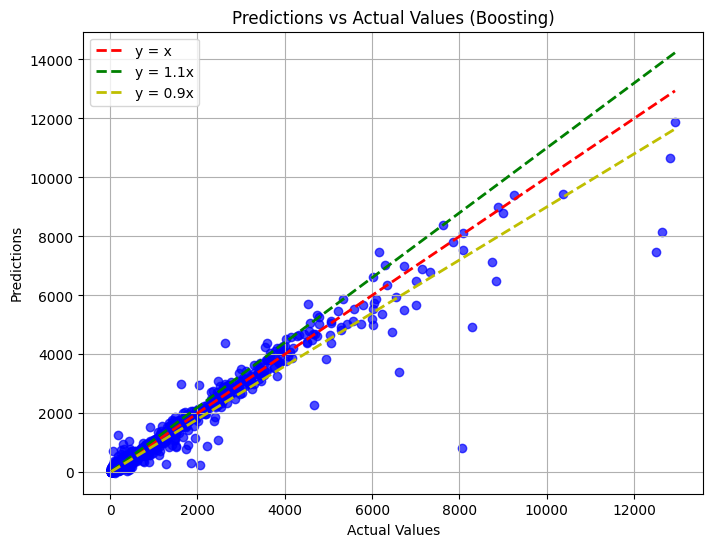

In [84]:
best_model_boosting.fit(X_train, y_train)
y_boosting_pred = best_model_boosting.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_boosting_pred, alpha=0.7, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label="y = x")
plt.plot([min(y_test), max(y_test)], [min(y_test) * 1.1, max(y_test) * 1.1], 'g--', lw=2, label="y = 1.1x")
plt.plot([min(y_test), max(y_test)], [min(y_test) * 0.9, max(y_test) * 0.9], 'y--', lw=2, label="y = 0.9x")
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Predictions vs Actual Values (Boosting)")
plt.legend()
plt.grid(True)
plt.show()


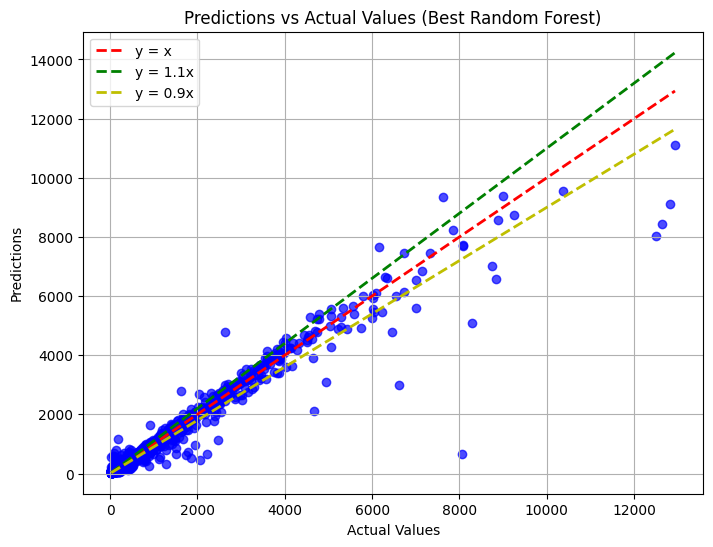

In [85]:
best_forest.fit(X_train, y_train)
y_forest_pred = best_forest.predict(X_test)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_forest_pred, alpha=0.7, color='b')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--', lw=2, label="y = x")
plt.plot([min(y_test), max(y_test)], [min(y_test) * 1.1, max(y_test) * 1.1], 'g--', lw=2, label="y = 1.1x")
plt.plot([min(y_test), max(y_test)], [min(y_test) * 0.9, max(y_test) * 0.9], 'y--', lw=2, label="y = 0.9x")
plt.xlabel("Actual Values")
plt.ylabel("Predictions")
plt.title("Predictions vs Actual Values (Best Random Forest)")
plt.legend()
plt.grid(True)
plt.show()



As shown in the graphs above, both models tend to make errors for very small and very large values. The error for the latter is largely contributing to the RMSE due to squaring the differences.

In the experiment, we discarded data below a given threshold, which, as suspected, significantly improved the models' ability to predict individual values accurately (more points fell within the acceptable 10% margin).

In our assessment, it is difficult to definitively determine which metric (RMSE, predictions within a 10% margin) is more important. A lower RMSE tells us about the average prediction performance, while the 10% margin focuses more on individual cases. From a producer's perspective, the 10% margin would likely be more significant.

In both of the best models, the outcome was practically determined by two features and their variations: 'Avg rating' and 'Geek Rating'. The decisive role of the latter could be anticipated based on the correlation matrix results, but the relatively increased importance of 'Avg rating' is quite interesting.

Our theory about the importance of the 'Geek Rating' feature is as follows: People who are passionate about board games play many different games and thus have a comparison of quality between them. Being deeply passionate about one of them, they are likely to recommend it to others in the engaged community, creating a "snowball effect." As the game gains interest, more and more people play it and provide ratings.

Since experts' voices are more influential than those of the average consumer, a layperson is likely to choose a game recommended by them. However, if the game catches the layperson's interest, they will be able to persuade fewer people to rate it than a 'geek'. The combination of these two features allows us to predict the overall population that will rate a particular game.

# Suggestions for Further Development
*   Build separate models for small and remaining values.
*   Develop a neural network to tackle this regression problem.
*   Expand the dataset.
*   Explore other models not used in this project, with particular focus on SVM models.
*   Conduct additional analysis on the potential of features created through polynomial features.